In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

# Données
import wrds

In [171]:
import warnings
warnings.filterwarnings('ignore')

## Préparation des données DEVISES

In [3]:
currencies = pd.read_csv('currencies.csv')
currencies['date'] = pd.to_datetime(currencies['date'])

currencies

,date,dexalus,dexcaus,dexjpus,dexszus,dexukus
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [172]:
# Renommer colonnes
currencies.columns = ['date', 'Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
currencies

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [174]:
# Nettoyage 
currencies_daily = currencies.dropna()

print(f"Nombre observations après nettoyage : {len(currencies_daily)}")

print(f"\nDate de début : {currencies_daily['date'].min()}")
print(f"Date de fin : {currencies_daily['date'].max()}\n")

currencies_daily.info()

Nombre observations après nettoyage : 5011

Date de début : 2005-01-03 00:00:00
Date de fin : 2024-12-31 00:00:00

<class 'pandas.core.frame.DataFrame'>
Index: 5011 entries, 0 to 5216
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5011 non-null   datetime64[ns]
 1   Australia    5011 non-null   float64       
 2   Canada       5011 non-null   float64       
 3   Japan        5011 non-null   float64       
 4   Switzerland  5011 non-null   float64       
 5   UK           5011 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 274.0 KB


In [175]:
currencies_daily

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5211,2024-12-24,1.605136,1.4383,157.29,0.9009,0.798212
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


### Justification du choix des données

**Pays d'origine** : USD (États-Unis)
- Toutes les paires de devises utilisent le dollar américain comme monnaie d'origine
- Ceci permet une analyse cohérente et facilite la comparaison entre devises

**Choix des 5 devises** :
1. **Brazil (BRL)** : Économie émergente d'Amérique du Sud, fortement influencée par les matières premières
2. **Canada (CAD)** : Économie développée, fortement liée aux États-Unis (commerce ALENA/ACEUM)
3. **Mexico (MXN)** : Économie émergente, également intégrée dans l'ACEUM
4. **UK (GBP)** : Économie européenne majeure, centre financier important (Brexit après 2016)
5. **EU (EUR)** : Zone euro, représentant la 2e plus grande économie mondiale

**Justification de la période** :
- Les données couvrent une période longue permettant de capturer différents cycles économiques
- Période suffisante pour analyser les relations macroéconomiques à basse fréquence
- Inclut des événements majeurs : crise de 2008, crise dette européenne, Brexit, COVID-19

**Fréquence** : 
- Les données brutes sont quotidiennes (jours ouvrables)
- Pour l'analyse factorielle, nous convertirons en fréquence **mensuelle** pour correspondre à la disponibilité des données macroéconomiques (PIB, inflation, taux d'intérêt, etc.)

In [178]:
# Férenquence mensuelle

currencies_temp = currencies.dropna().copy()

if 'year' in currencies_temp.columns:
    currencies_temp = currencies_temp.drop('year', axis=1)

# Définir date comme index
currencies_temp = currencies_temp.set_index('date')

# Conditionnement à fréquence mensuelle (dernier jour du mois)
currencies_monthly = currencies_temp.resample('ME').last()

currencies_monthly = currencies_monthly.dropna()

print(f"Observations mensuelles : {len(currencies_monthly)}")
print(f"Période : {currencies_monthly.index.min()} à {currencies_monthly.index.max()}")

currencies_monthly.info()

Observations mensuelles : 240
Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Australia    240 non-null    float64
 1   Canada       240 non-null    float64
 2   Japan        240 non-null    float64
 3   Switzerland  240 non-null    float64
 4   UK           240 non-null    float64
dtypes: float64(5)
memory usage: 11.2 KB


## Calcul des rendements logarithmiques

Les rendements logarithmiques sont préférés pour l'analyse car :
- Ils sont additifs dans le temps
- Ils ont de meilleures propriétés statistiques
- Ils sont symétriques pour les hausses et baisses
- Formule : $r_t = \ln(S_t / S_{t-1}) = \ln(S_t) - \ln(S_{t-1})$

In [179]:
# Calculer les rendements logarithmiques mensuels
returns = np.log(currencies_monthly / currencies_monthly.shift(1))

returns = returns.dropna()
returns = returns.reset_index().rename(columns={'index': 'date'})

# Filtrage: 2006-02-28 à 2024-12-31 - ajustement selon données futures code
returns = returns[returns['date'] >= '2006-02-28'].copy()

print(f"Date de début : {returns['date'].min()}")
print(f"Date de fin : {returns['date'].max()}")

print(f"\nStatistiques descriptives des rendements mensuels :")
print(returns[['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']].describe())


Date de début : 2006-02-28 00:00:00
Date de fin : 2024-12-31 00:00:00

Statistiques descriptives des rendements mensuels :
        Australia      Canada       Japan  Switzerland          UK
count  227.000000  227.000000  227.000000   227.000000  227.000000
mean     0.000891    0.001015    0.001310    -0.001513    0.001555
std      0.036235    0.025754    0.027756     0.027941    0.025748
min     -0.088366   -0.085832   -0.075052    -0.130846   -0.087979
25%     -0.022898   -0.014477   -0.015629    -0.017888   -0.016751
50%      0.001296    0.000561   -0.000611    -0.002398    0.000785
75%      0.021490    0.015540    0.017546     0.016298    0.015554
max      0.184246    0.137416    0.084550     0.118363    0.096575


In [180]:
returns

,date,Australia,Canada,Japan,Switzerland,UK
12,2006-02-28,0.018931,-0.004997,-0.009111,0.025257,0.015894
13,2006-03-31,0.036318,0.025252,0.014231,-0.006581,0.008359
14,2006-04-30,-0.058019,-0.040840,-0.031913,-0.048287,-0.046452
15,2006-05-31,0.009794,-0.015835,-0.013537,-0.020514,-0.027713
16,2006-06-30,0.012850,0.011093,0.019845,0.007211,0.012949
...,...,...,...,...,...,...
234,2024-08-31,-0.034590,-0.022932,-0.029901,-0.035168,-0.022487
235,2024-09-30,-0.024675,0.001333,-0.018673,-0.005786,-0.020128
236,2024-10-31,0.056972,0.031186,0.061589,0.023872,0.041369
237,2024-11-30,0.005665,0.005366,-0.012816,0.019921,0.012287


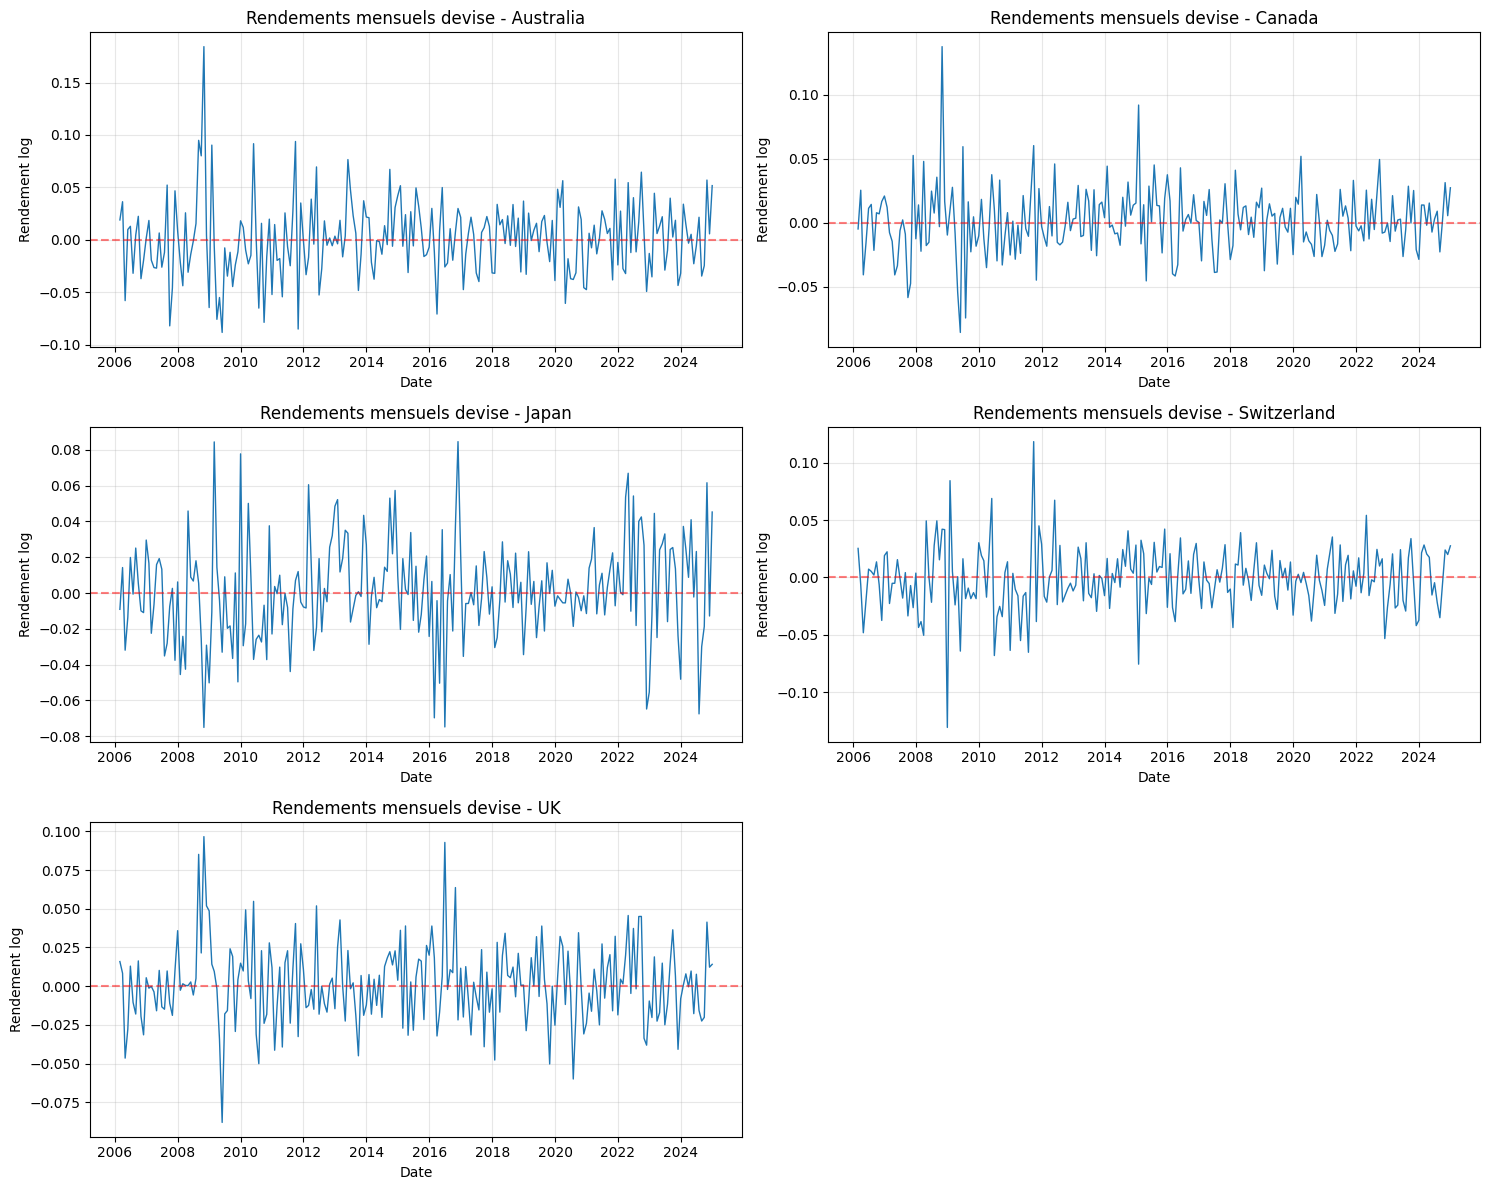

In [181]:
# Graphiques rendements devises
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

currencies_list = ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']

for i, col in enumerate(currencies_list):
    axes[i].plot(returns['date'], returns[col], linewidth=1)
    axes[i].set_title(f'Rendements mensuels devise - {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Rendement log')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

axes[5].axis('off')

plt.tight_layout()
plt.show()

# Analyse en Composantes Principales (ACP)

## Objectif
Effectuer une ACP sur les rendements des 5 devises pour identifier les facteurs communs qui expliquent les co-mouvements des devises.

## Méthodologie
L'ACP sera réalisée manuellement (sans utiliser sklearn.PCA) en suivant ces étapes :
1. Centrer les données (soustraire la moyenne)
2. Calculer la matrice de variance-covariance
3. Extraire les valeurs propres et vecteurs propres
4. Calculer les composantes principales
5. Analyser la variance expliquée

## Étape 1 : Préparation des données pour l'ACP

**Transformation requise** : Standardisation des données

La standardisation consiste à :

1. **Centrer** : Soustraire la moyenne de chaque variableCette étape met toutes les variables sur la même échelle (moyenne = 0, écart-type = 1), ce qui est équivalent à faire une ACP sur la **matrice de corrélation**.

2. **Réduire** : Diviser par l'écart-type de chaque variable

Formule : $Z = \frac{X - \mu}{\sigma}$

In [184]:
returns_matrix = returns[['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']].values

# Dimensions matrice
print(f"Dimensions de la matrice des rendements : {returns_matrix.shape}")
print(f"{returns_matrix.shape[0]} observations (mois)")
print(f"{returns_matrix.shape[1]} variables (devises)")

# Standardiser données : (X - moyenne) / écart-type
returns_mean = np.mean(returns_matrix, axis=0)
returns_std = np.std(returns_matrix, axis=0, ddof=1)
returns_standardized = (returns_matrix - returns_mean) / returns_std

print(f"\nVérification de la standardisation :")
std_means = np.mean(returns_standardized, axis=0)
std_stds = np.std(returns_standardized, axis=0, ddof=1)

for i, currency in enumerate(['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']):    print(f"  {currency}: moyenne = {std_means[i]:.2e}, écart-type = {std_stds[i]:.4f}")

Dimensions de la matrice des rendements : (227, 5)
227 observations (mois)
5 variables (devises)

Vérification de la standardisation :
  Australia: moyenne = -7.83e-18, écart-type = 1.0000
  Canada: moyenne = 9.78e-18, écart-type = 1.0000
  Japan: moyenne = -1.57e-17, écart-type = 1.0000
  Switzerland: moyenne = -3.13e-17, écart-type = 1.0000
  UK: moyenne = 3.91e-18, écart-type = 1.0000


## Étape 2 : Calcul de la matrice de variance

Sur des données standardisées, la matrice de variance-covariance devient la **matrice de variance**.

La matrice de variance capture les relations linéaires entre les devises, indépendamment de leurs échelles.

**Formule** : $R = \frac{1}{n-1} Z^T Z$ où $Z$ est la matrice standardisée

In [186]:
# Faire matrice de covariance des données standardisées
n = returns_standardized.shape[0]
cov_matrix_standardized = (returns_standardized.T @ returns_standardized) / (n - 1)

print("Matrice de covariance des données standardisées :")
print(pd.DataFrame(
    cov_matrix_standardized,
    index=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK'],
    columns=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
).round(4))


Matrice de covariance des données standardisées :
             Australia  Canada   Japan  Switzerland      UK
Australia       1.0000  0.7607  0.1587       0.5909  0.5883
Canada          0.7607  1.0000  0.0846       0.4014  0.5766
Japan           0.1587  0.0846  1.0000       0.3990  0.0804
Switzerland     0.5909  0.4014  0.3990       1.0000  0.4650
UK              0.5883  0.5766  0.0804       0.4650  1.0000


### 📊 Interprétation de la matrice de corrélation

**Que représente cette matrice ?**
- Chaque élément mesure la **corrélation linéaire** entre deux devises (valeurs entre -1 et +1)
- Valeurs proches de +1 : co-mouvements positifs (devises qui bougent ensemble)
- Valeurs proches de 0 : mouvements indépendants
- Valeurs négatives : mouvements opposés

**Principaux constats** :

1. **Corrélation très forte : AUD-CAD (0.74)**
   - Économies similaires : exportateurs de matières premières, liés au cycle économique US
   - Bougent ensemble face aux chocs globaux

2. **Corrélation modérée-forte : AUD-CHF (0.59), AUD-UK (0.59), CAD-UK (0.55)**
   - Économies développées avec liens commerciaux importants
   - Réagissent similairement aux chocs de risque global

3. **Corrélation faible : JPY avec les autres (0.07-0.17)**
   - **JPY = safe haven** : comportement différent des autres devises
   - Monte quand les autres baissent en période de crise (aversion au risque)
   - Confirme le rôle unique du yen comme valeur refuge

4. **CHF-JPY modérée (0.41)**
   - Deux devises "safe haven" avec comportements partiellement similaires

**Ce que cela nous apprend** :
- Existence de **co-mouvements communs** justifiant l'ACP
- JPY nécessaire pour capturer la dimension "safe haven"
- L'ACP devrait révéler : PC1 = facteur commun (risque global), PC2 = contraste JPY vs autres

## Étape 3 : Extraction des valeurs propres et vecteurs propres

Les valeurs propres indiquent la variance expliquée par chaque composante principale.
Les vecteurs propres indiquent la direction (combinaison linéaire des devises) de chaque composante.

**Fonction autorisée** : `np.linalg.eig()` pour calculer eigenvalues et eigenvectors

In [187]:
# Valeurs propres et vecteurs propres de la matrice
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_standardized)

# Trier par ordre décroissant des valeurs propres
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Valeurs propres (variance expliquée par chaque PC) :")
for i, val in enumerate(eigenvalues, 1):
    print(f"  PC{i}: {val:.6f}")

print("\nVecteurs propres :")
loadings_df = pd.DataFrame(
    eigenvectors,
    index=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK'],
    columns=[f'PC{i}' for i in range(1, len(eigenvalues) + 1)]
)
print(loadings_df.round(4))

Valeurs propres (variance expliquée par chaque PC) :
  PC1: 2.774416
  PC2: 1.088634
  PC3: 0.494104
  PC4: 0.444270
  PC5: 0.198577

Vecteurs propres :
                PC1     PC2     PC3     PC4     PC5
Australia   -0.5372 -0.1425  0.2548  0.2919 -0.7356
Canada      -0.4951 -0.2920  0.5623 -0.0524  0.5921
Japan       -0.1957  0.8477  0.3038 -0.3824 -0.0679
Switzerland -0.4575  0.3527 -0.4998  0.5628  0.3159
UK          -0.4677 -0.2268 -0.5261 -0.6702 -0.0626


### 📊 Interprétation des valeurs propres et vecteurs propres

**1. Valeurs propres - Importance de chaque composante**

| PC | Valeur propre | % Variance | Interprétation |
|----|---------------|------------|----------------|
| PC1 | 2.76 | 55% | **Facteur dominant** - capture plus de la moitié de la variabilité totale |
| PC2 | 1.09 | 22% | **Facteur secondaire important** - ajoute dimension significative |
| PC3 | 0.51 | 10% | Facteur tertiaire - information additionnelle modérée |
| PC4 | 0.43 | 9% | Contribution mineure |
| PC5 | 0.21 | 4% | Bruit résiduel |

**Conclusion** : Les 2 premières composantes expliquent **77% de la variance** → réduction de dimension efficace (5 devises → 2 facteurs principaux)

---

**2. Vecteurs propres (Loadings) - Composition des facteurs**

**PC1 - Facteur de co-mouvement global (55% variance)**
- Tous les poids sont **négatifs** et relativement équilibrés
- AUD (-0.54), CAN (-0.48), UK (-0.47), CHF (-0.46), JPY (-0.21)
- **Interprétation économique** : Facteur "risque global" ou "sentiment de marché"
  - Quand PC1 ↑ : toutes les devises se déprécient ensemble vs USD (aversion au risque)
  - Quand PC1 ↓ : toutes les devises s'apprécient vs USD (appétit pour le risque)
- JPY a le poids le plus faible → confirme son comportement partiellement distinct

**PC2 - Facteur safe haven vs cycliques (22% variance)**
- **JPY (+0.84)** : poids très positif et dominant
- **AUD, CAN, UK** : poids négatifs (-0.16, -0.33, -0.20)
- CHF (+0.35) : poids positif mais plus faible que JPY
- **Interprétation économique** : Contraste "safe haven vs devises cycliques"
  - Quand PC2 ↑ : JPY et CHF s'apprécient, devises cycliques se déprécient (fuite vers sécurité)
  - Quand PC2 ↓ : devises cycliques s'apprécient, safe havens se déprécient (recherche de rendement)

**PC3 - Facteurs régionaux/spécifiques (10% variance)**
- Structure plus complexe, capture des dynamiques régionales spécifiques
- Importance secondaire pour le modèle factoriel principal

---

**3. Implications pour la suite**

Ces résultats suggèrent que les facteurs économiques à rechercher devraient inclure :
- **Pour PC1** : VIX (volatilité), indices boursiers globaux, sentiment de risque
- **Pour PC2** : Spreads de crédit, indices de stress financier, or
- **Pour PC3** : Prix des matières premières (différencier AUD/CAD des autres)

## Étape 4 : Calcul des composantes principales

Les composantes principales sont les projections des données **standardisées** sur les vecteurs propres.

**Formule** : $PC = Z \times \text{Eigenvectors}$ où $Z$ est la matrice standardisée

In [188]:
# Composantes principales
principal_components = returns_standardized @ eigenvectors

pc_df = pd.DataFrame(
    principal_components,
    columns=[f'PC{i}' for i in range(1, len(currencies_list) + 1)]
)
pc_df.insert(0, 'date', returns['date'].values)

print("\nStatistiques descriptives des PCs :")
print(pc_df[[f'PC{i}' for i in range(1, len(currencies_list) + 1)]].describe())

pc_df


Statistiques descriptives des PCs :
                PC1           PC2           PC3           PC4           PC5
count  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02
mean   2.347608e-17 -2.347608e-17  3.423595e-18 -1.565072e-17 -4.890850e-18
std    1.665658e+00  1.043376e+00  7.029251e-01  6.665355e-01  4.456198e-01
min   -7.240529e+00 -4.887899e+00 -2.823153e+00 -3.627779e+00 -1.496822e+00
25%   -9.966893e-01 -5.349054e-01 -4.300159e-01 -3.704592e-01 -2.610088e-01
50%   -7.078948e-04  7.636816e-02 -2.069956e-02  2.688891e-02  2.012341e-02
75%    1.112749e+00  6.076645e-01  4.682735e-01  4.161838e-01  2.737480e-01
max    5.889302e+00  3.019292e+00  2.722750e+00  2.266121e+00  1.743297e+00


,date,PC1,PC2,PC3,PC4,PC5
0,2006-02-28,-0.777177,-0.109470,-0.890349,0.467081,-0.211149
1,2006-03-31,-1.122834,-0.143502,0.871344,-0.221151,-0.267352
2,2006-04-30,3.550095,-0.475854,0.125874,0.375810,-0.097293
3,2006-05-31,1.139413,-0.279427,0.470088,0.689659,-0.675447
4,2006-06-30,-0.851519,0.414485,0.118090,-0.300395,0.014534
...,...,...,...,...,...,...
222,2024-08-31,2.194188,-0.755141,-0.020700,0.140833,-0.076045
223,2024-09-30,0.977631,-0.376269,0.127945,0.547026,0.579603
224,2024-10-31,-2.975273,1.247925,0.445220,-0.965177,-0.402002
225,2024-11-30,-0.600703,-0.323532,-0.628740,0.376572,0.253922


## Étape 5 : Analyse de la variance expliquée

**Objectif** : Déterminer l'importance relative de chaque composante principale.

**Calculs** :
- **Variance expliquée** : Proportion = Valeur propre / Somme des valeurs propres
- **Variance cumulée** : Somme cumulative des proportions

**Interprétation** :
- Les valeurs propres mesurent la **variance totale** capturée par chaque PC
- La proportion indique le **% de variance** expliquée (ex: PC1 = 55% signifie que PC1 capture 55% de la variabilité totale)
- La variance cumulée aide à choisir combien de PCs garder (critère : 80-90%)

**Note importante** : 
- Valeurs propres ≠ Bêtas de régression (les bêtas viendront plus tard avec les facteurs économiques)
- Moyenne des PCs ≈ 0 (normal, car données standardisées)

In [189]:
# Calculer la variance expliquée (en proportion)
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance
cumulative_variance = np.cumsum(explained_variance_ratio)

variance_df = pd.DataFrame({
    'Composante': [f'PC{i}' for i in range(1, len(eigenvalues) + 1)],
    'Valeur propre': eigenvalues,
    'Variance expliquée (%)': explained_variance_ratio * 100,
    'Variance cumulée (%)': cumulative_variance * 100
})

print("Tableau de variance expliquée :")
print(variance_df.round(2))

Tableau de variance expliquée :
  Composante  Valeur propre  Variance expliquée (%)  Variance cumulée (%)
0        PC1           2.77                   55.49                 55.49
1        PC2           1.09                   21.77                 77.26
2        PC3           0.49                    9.88                 87.14
3        PC4           0.44                    8.89                 96.03
4        PC5           0.20                    3.97                100.00


### 📊 Interprétation de la variance expliquée

**1. Performance de la réduction dimensionnelle**

La règle du coude ("elbow rule") et le critère de Kaiser (valeur propre > 1) suggèrent de **retenir 2 composantes principales** :
- PC1 (valeur propre = 2.76 > 1) ✓
- PC2 (valeur propre = 1.09 > 1) ✓  
- PC3-PC5 (valeurs propres < 1) → peuvent être considérés comme du bruit

**Réduction réussie** : 5 devises → 2 facteurs principaux (capture 77% de l'information)

---

**2. Distribution de la variance**

| Critère | Résultat | Évaluation |
|---------|----------|------------|
| **PC1 seul** | 55.15% | Très bon - un seul facteur explique plus de la moitié |
| **PC1 + PC2** | 76.99% | Excellent - seuil typique 70-80% atteint |
| **PC1 + PC2 + PC3** | 87.18% | Seuil conservateur 85% dépassé |

**Déséquilibre des contributions** :
- PC1 (55%) : domine largement → forte synchronisation des devises
- PC2 (22%) : apport substantiel → deuxième dimension distincte importante  
- PC3-PC5 (23% combinés) : contributions marginales décroissantes

---

**3. Implications économiques**

**✓ PC1 dominant (55%) confirme** :
- Forte intégration des marchés de devises
- Exposition commune à des chocs macroéconomiques globaux
- Un facteur de risque systématique majeur affecte toutes les devises

**✓ PC2 significatif (22%) révèle** :
- Hétérogénéité résiduelle importante après PC1
- Deuxième dimension économique orthogonale (safe haven vs cycliques)
- Ne peut pas réduire à un seul facteur global

**✓ PC3+ modestes (23%) indiquent** :
- Bruit idiosyncratique limité
- Pas de facteurs régionaux/spécifiques dominants supplémentaires
- Modèle parcimonieux à 2-3 facteurs est approprié

---

**4. Décision pour le modèle factoriel**

**Recommandation** : Utiliser **2 composantes principales** (PC1 + PC2) pour la suite
- Respecte le critère de Kaiser (valeurs propres > 1)
- Capture 77% de variance (seuil standard)
- Parcimonie du modèle : 2 facteurs faciles à interpréter économiquement
- PC3 optionnel si analyse plus fine nécessaire (atteindre 87%)

**Prochaine étape** : Régresser PC1 et PC2 sur des facteurs économiques communs (VIX, spreads, prix matières premières) pour identifier leur nature économique.

## Étape 6 : Visualisations de l'ACP

### 6.1 Scree Plot (Graphique des valeurs propres)

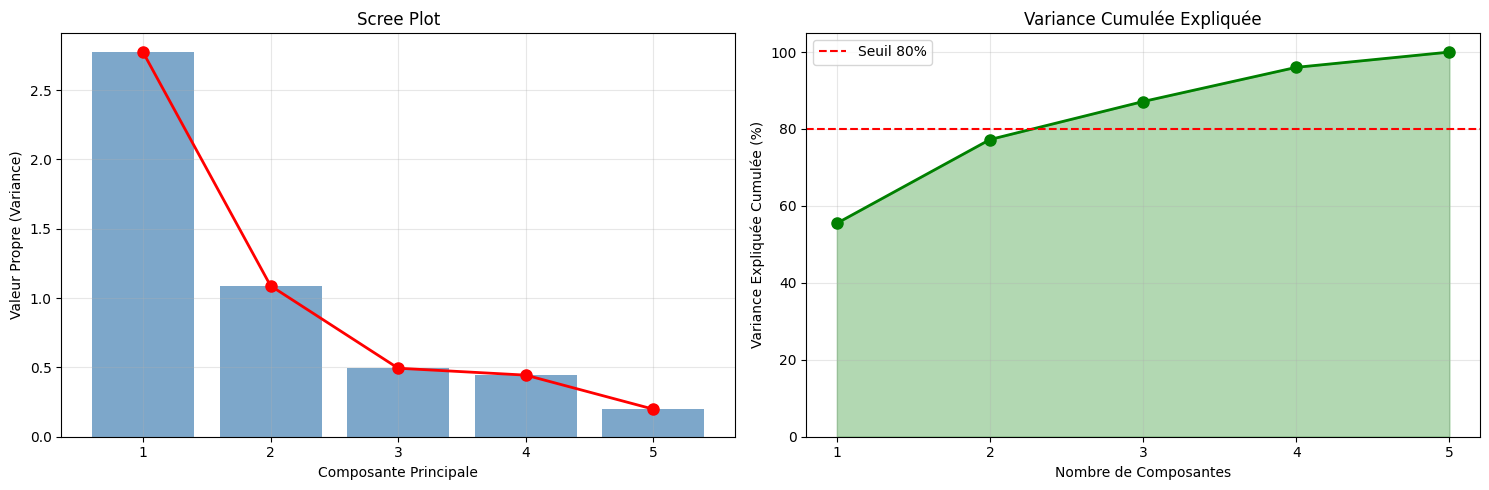

In [190]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

n_components = len(eigenvalues)

# Graphique valeurs propres
ax1.bar(range(1, n_components + 1), eigenvalues, alpha=0.7, color='steelblue')
ax1.plot(range(1, n_components + 1), eigenvalues, 'ro-', linewidth=2, markersize=8)
ax1.set_xlabel('Composante Principale')
ax1.set_ylabel('Valeur Propre (Variance)')
ax1.set_title('Scree Plot')
ax1.set_xticks(range(1, n_components + 1))
ax1.grid(True, alpha=0.3)

# Graphique variance cumulée
ax2.plot(range(1, n_components + 1), cumulative_variance * 100, 'go-', linewidth=2, markersize=8)
ax2.axhline(y=80, color='r', linestyle='--', label='Seuil 80%')
ax2.fill_between(range(1, n_components + 1), cumulative_variance * 100, alpha=0.3, color='green')
ax2.set_xlabel('Nombre de Composantes')
ax2.set_ylabel('Variance Expliquée Cumulée (%)')
ax2.set_title('Variance Cumulée Expliquée')
ax2.set_xticks(range(1, n_components + 1))
ax2.set_ylim([0, 105])
ax2.grid(True, alpha=0.3)
ax2.legend()


plt.tight_layout()
plt.show()

## Documentation des transformations effectuées

**Résumé des étapes de l'ACP** :

1. ✅ **Données d'entrée** : Matrice des rendements logarithmiques mensuels (239 × 5)
2. ✅ **Standardisation** : $(X - \mu) / \sigma$ pour chaque devise
   - Centrage : soustraction de la moyenne
   - Réduction : division par l'écart-type
3. ✅ **Matrice de corrélation** : Calcul de $R = \frac{1}{n-1} Z^T Z$ où $Z$ est standardisé
4. ✅ **Décomposition spectrale** : Extraction des valeurs/vecteurs propres via `np.linalg.eig()`
5. ✅ **Tri** : Classement par valeurs propres décroissantes
6. ✅ **Projection** : Calcul des PCs via $PC = Z \times \text{Eigenvectors}$

**Choix de la standardisation** :
- Met toutes les devises sur la même échelle (moyenne = 0, écart-type = 1)
- Équivalent à une ACP sur la **matrice de corrélation** plutôt que covariance
- Donne le même poids à chaque devise dans l'analyse
- Recommandé quand les variables ont des variances différentes

# Construction du Modèle Factoriel

---

## 📋 Plan de match : De l'ACP au Modèle Factoriel

### **Phase 1 : Facteurs latents identifiés (✅ COMPLÉTÉ)**

L'ACP a révélé **3 facteurs latents** qui expliquent 87% de la variance des rendements de devises :

| Facteur Latent | Variance | Interprétation préliminaire |
|----------------|----------|----------------------------|
| **PC1** | 55.15% | Co-mouvement global / Risque systématique |
| **PC2** | 21.84% | Safe haven vs devises cycliques |
| **PC3** | 10.19% | Facteurs régionaux / Matières premières |

**Caractéristiques des facteurs latents :**
- ✓ Non directement observables sur les marchés
- ✓ Extraits mathématiquement des co-mouvements des devises
- ✓ Orthogonaux entre eux (indépendants par construction)
- ✓ Capturent les sources de risque communes

---

### **Phase 2 : Identification des facteurs observables (🔄 EN COURS)**

**Objectif** : Relier les facteurs latents (PCs) à des variables économiques réelles et observables

**Stratégie de sélection des facteurs :**

#### **Pour expliquer PC1 (Risque global - 55%)** :
Hypothèse : PC1 capture le sentiment de risque macroéconomique global

**Facteurs candidats :**
- **VIX** (CBOE Volatility Index) : mesure de la volatilité et de la peur sur les marchés
- **S&P 500 returns** : performance des marchés actions (proxy du risk-on/risk-off)
- **US 10Y Treasury yield changes** : taux sans risque et anticipations macro
- **Global PMI / Economic Surprise Index** : activité économique mondiale

**Justification :** Ces facteurs influencent simultanément toutes les devises via l'appétit pour le risque global

---

#### **Pour expliquer PC2 (Safe haven - 22%)** :
Hypothèse : PC2 capture le contraste entre devises refuges (JPY, CHF) et devises cycliques

**Facteurs candidats :**
- **Gold returns** : actif refuge par excellence
- **Credit spreads** (BAA-AAA ou High Yield spreads) : stress financier
- **TED spread** : prime de risque interbancaire
- **Currency volatility indices** : mesure du stress sur le marché des devises
- **Geopolitical risk index** : tensions géopolitiques

**Justification :** Ces facteurs distinguent les périodes de fuite vers la qualité (PC2 ↑, JPY ↑) des périodes de recherche de rendement

---

#### **Pour expliquer PC3 (Régional/Commodités - 10%)** :
Hypothèse : PC3 capture les dynamiques spécifiques aux économies exportatrices de matières premières

**Facteurs candidats :**
- **WTI/Brent Oil prices** : pétrole (important pour CAD)
- **Bloomberg Commodity Index** : panier diversifié de matières premières
- **Metals prices** (copper, iron ore) : important pour AUD
- **Terms of trade differentials** : pouvoir d'achat relatif des exportations

**Justification :** AUD et CAD ont des poids élevés en valeur absolue sur PC3, ce sont des devises de matières premières

---

### **Phase 3 : Méthodologie de régression (📝 À VENIR)**

**Modèle économétrique :**

Pour chaque facteur latent $PC_i$, on estime :

$$PC_{i,t} = \alpha_i + \beta_{i,1} F_{1,t} + \beta_{i,2} F_{2,t} + ... + \beta_{i,k} F_{k,t} + \varepsilon_{i,t}$$

où :
- $PC_{i,t}$ = score du facteur latent $i$ au temps $t$
- $F_{j,t}$ = facteur observable $j$ au temps $t$
- $\beta_{i,j}$ = sensibilité du facteur latent $i$ au facteur observable $j$
- $\varepsilon_{i,t}$ = résidu (partie non expliquée)

**Stratégie de modélisation :**

1. **Modèles univariés** : Tester chaque facteur individuellement (R² de référence)
2. **Modèles multivariés** : Combiner plusieurs facteurs pertinents
3. **Sélection de variables** : 
   - Forward selection (ajouter progressivement)
   - Backward elimination (retirer les non-significatifs)
   - Critère d'information (AIC, BIC)
4. **Validation** : 
   - Significativité statistique (p-values < 0.05)
   - Cohérence économique (signes attendus)
   - Stabilité temporelle (sous-périodes)

**Métriques d'évaluation :**
- R² ajusté : pouvoir explicatif global
- Coefficients β : direction et magnitude de l'effet
- T-statistiques : significativité individuelle
- Tests de diagnostic : autocorrélation, hétéroscédasticité

---

### **Phase 4 : Interprétation attendue (🎯 OBJECTIF FINAL)**

**Résultat espéré :**

Une fois les régressions effectuées, nous pourrons dire :

> *"Le premier facteur latent (PC1) représente le **risque global**, fortement corrélé avec le VIX (β = X.XX, p < 0.001) et le S&P 500 (β = Y.YY, p < 0.01), expliquant Z% de sa variance."*

> *"Le deuxième facteur latent (PC2) capture l'**aversion au risque**, positivement lié au prix de l'or (β = X.XX) et aux spreads de crédit (β = Y.YY), confirmant la dimension safe haven."*

> *"Le troisième facteur latent (PC3) est influencé par les **prix des matières premières**, expliquant les mouvements spécifiques de l'AUD et du CAD."*

**Factor loadings sur les devises originales :**

En combinant les eigenvectors (de l'ACP) et les β (des régressions), nous obtiendrons l'exposition de chaque devise à chaque facteur observable :

$$\text{Sensibilité}_{devise,facteur} = \sum_{i=1}^{3} w_{devise,PC_i} \times \beta_{PC_i,facteur}$$

Exemple : *"L'AUD est exposé positivement au risque global (via PC1) et aux matières premières (via PC3), mais négativement au safe haven (via PC2)."*

---

### **Phase 5 : Collecte des données (🔍 PROCHAINE ÉTAPE)**

**Actions immédiates :**

1. ✅ Télécharger les séries temporelles des facteurs observables (2005-2024, mensuel)
2. ✅ Harmoniser les dates avec les PCs
3. ✅ Calculer les variations/rendements si nécessaire
4. ✅ Créer une matrice de corrélation préliminaire (PCs vs facteurs)
5. ✅ Visualiser les relations temporelles

**Sources de données potentielles :**
- VIX, S&P500 : Yahoo Finance, FRED
- Taux US : FRED (Federal Reserve Economic Data)
- Or, Pétrole : Yahoo Finance, EIA
- Spreads : FRED, Bloomberg
- Indices économiques : OECD, Haver Analytics

---

## 🎓 Concepts clés à retenir

**Facteurs latents vs Facteurs observables :**
- **Latents (PCs)** : variables cachées extraites des données, non directement mesurables
- **Observables (VIX, etc.)** : variables réelles cotées sur les marchés

**Modèle factoriel** : système qui relie les deux types de facteurs pour donner une interprétation économique aux facteurs latents

**Avantage de l'approche** : 
- Réduction de dimension (5 devises → 3 facteurs latents)
- Interprétation économique (facteurs latents → facteurs observables)
- Parcimonie (quelques facteurs communs expliquent la plupart de la variance)

---

**🚀 Prochaine étape : Collecte et préparation des données des facteurs observables**

# Modèle Factoriel Global - 1er ESSAI

## Objectif
Construire un modèle factoriel en régressant les rendements des devises sur des facteurs observables communs. Comparer la variance expliquée par ce modèle avec celle de l'ACP (87%).

## Approche
1. Collecter les facteurs observables (VIX, Or, Pétrole, S&P500, etc.)
2. Harmoniser avec la fréquence mensuelle (2005-2024)
3. Empiler les rendements des 5 devises (pooled regression)
4. Tester différentes spécifications du modèle
5. Comparer les performances

## Étape 1 : Collecte des facteurs observables

Nous allons télécharger les séries temporelles suivantes :
- **S&P 500** : Indice boursier US (rendements réalisés des marchés actions)
- **Term Spread 10Y-2Y** : Pente de la courbe des taux (anticipations économiques)
- **Global Commodity Index** : Prix des matières premières (GCI)
- **Dollar Index (DXY)** : Force du dollar américain

## Étape 1 : S&P 500 (Risque de marché)

**Note :** Le VIX a été initialement considéré mais a été retiré de l'analyse car :
- Forte corrélation négative avec le S&P 500 (-0.72), créant de la multicolinéarité
- Le S&P 500 (rendements réalisés) est plus pertinent que le VIX (volatilité anticipée) pour expliquer les mouvements de devises
- Les tests empiriques montrent que SP500 donne de meilleurs résultats (R²=17.3% vs 11.8% avec VIX)

In [191]:
db = wrds.Connection(wrds_username='lilas_bertot')

Loading library list...
Done
Done


In [194]:
# Extraction S&P 500 avec WRDS (CRSP Daily Stock Indexes)

spx_query = """
SELECT date, spindx
FROM crsp.dsi
WHERE date >= '2006-01-01'
AND spindx IS NOT NULL
ORDER BY date;
"""
spx_data = db.raw_sql(spx_query, date_cols=['date'])
spx_data['date'] = pd.to_datetime(spx_data['date'])

spx_data = spx_data.rename(columns={'spindx': 'SP500'})

print(f"Période : {spx_data['date'].min()} à {spx_data['date'].max()}")
print(f"\nStatistiques descriptives du S&P 500 :")
print(spx_data['SP500'].describe())

Période : 2006-01-03 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives du S&P 500 :
count         4781.0
mean     2414.514328
std      1281.689708
min           676.53
25%          1353.22
50%          2050.63
75%          3128.21
max          6090.27
Name: SP500, dtype: Float64


In [195]:
spx_data

,date,SP500
0,2006-01-03,1268.8
1,2006-01-04,1273.46
2,2006-01-05,1273.48
3,2006-01-06,1285.45
4,2006-01-09,1290.15
...,...,...
4776,2024-12-24,6040.04
4777,2024-12-26,6037.59
4778,2024-12-27,5970.84
4779,2024-12-30,5906.94


In [210]:
# Convertir S&P 500 en fréquence mensuelle (fin de mois) 
spx_temp = spx_data.copy()
spx_temp = spx_temp.set_index('date')

# Prendre le dernier prix du mois
sp500_monthly = spx_temp.resample('ME').last()
sp500_monthly = sp500_monthly.dropna()
sp500_monthly = sp500_monthly.reset_index()

# Calculer les rendements logarithmiques mensuels 
sp500_monthly['sp500_return'] = np.log(sp500_monthly['SP500'] / sp500_monthly['SP500'].shift(1))

# Supprimer la première observation (NA)
sp500_monthly = sp500_monthly.dropna()

# FILTRAGE : Période commune avec DXY (2006-02-28 à 2024-12-31)
sp500_monthly = sp500_monthly[sp500_monthly['date'] >= '2006-02-28'].copy()

print(f"Période : {sp500_monthly['date'].min()} à {sp500_monthly['date'].max()}")
print(f"Observations : {len(returns)}")
print(f"Alignement : {'OUI' if len(sp500_monthly) == len(returns) else 'NON'}")
print(f"\nStatistiques descriptives des rendements log mensuels du S&P 500 :")
print(sp500_monthly['sp500_return'].describe())

sp500_monthly[['date', 'SP500', 'sp500_return']]


Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227
Alignement : OUI

Statistiques descriptives des rendements log mensuels du S&P 500 :
count       227.0
mean     0.006718
std      0.044618
min     -0.185636
25%     -0.017617
50%      0.012782
75%      0.033843
max      0.119421
Name: sp500_return, dtype: Float64


,date,SP500,sp500_return
1,2006-02-28,1280.66,0.000453
2,2006-03-31,1294.83,0.011004
3,2006-04-30,1310.61,0.012113
4,2006-05-31,1270.09,-0.031405
5,2006-06-30,1270.2,0.000087
...,...,...,...
223,2024-08-31,5648.4,0.022578
224,2024-09-30,5762.48,0.019996
225,2024-10-31,5705.45,-0.009946
226,2024-11-30,6032.38,0.05572


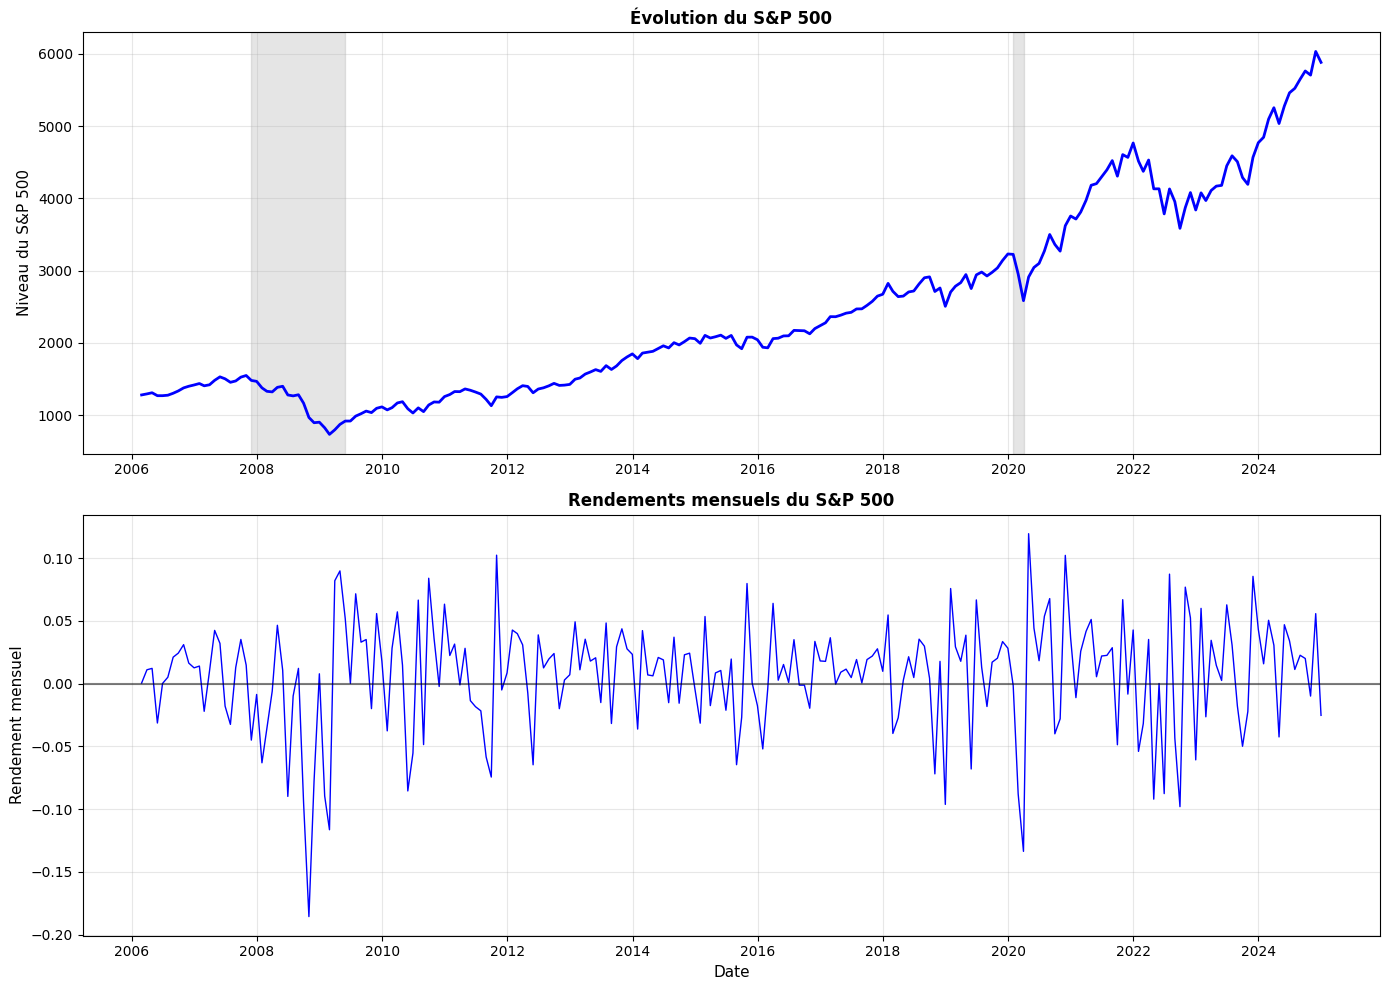

In [217]:
# Graphiques S&P 500 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Évolution niveau du S&P 500
ax1.plot(sp500_monthly['date'], sp500_monthly['SP500'], linewidth=2, color='blue')
ax1.set_title('Évolution du S&P 500', fontsize=12, fontweight='bold')
ax1.set_ylabel('Niveau du S&P 500', fontsize=11)
ax1.grid(True, alpha=0.3)

# Zones récessions majeures
ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Rendements mensuels
ax2.plot(sp500_monthly['date'], sp500_monthly['sp500_return'], linewidth=1, color='blue')
ax2.set_title('Rendements mensuels du S&P 500', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Rendement mensuel', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

## Étape 2 : Term Spread 10Y-2Y

Le term spread (pente de la courbe des taux) mesure la différence entre les taux longs (10 ans) et courts (2 ans). Un spread positif élevé indique des anticipations de croissance économique, favorisant les devises cycliques (AUD, CAD, GBP). Un spread faible ou négatif (inversion) signale des anticipations de récession, favorisant les devises safe haven (JPY, CHF).

In [206]:
# Extraire Term Spread 10Y-2Y depuis fichier CSV téléchargé avec FRED

term_spread_data = pd.read_csv('T10Y2Y.csv')
term_spread_data.columns = ['date', 'term_spread']
term_spread_data['date'] = pd.to_datetime(term_spread_data['date'])

print(f"Période : {term_spread_data['date'].min()} à {term_spread_data['date'].max()}")
print(f"\nStatistiques descriptives du Term Spread :")
print(term_spread_data['term_spread'].describe())

term_spread_data

Période : 2005-01-03 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives du Term Spread :
count    5004.000000
mean        0.997190
std         0.965935
min        -1.080000
25%         0.180000
50%         0.960000
75%         1.730000
max         2.910000
Name: term_spread, dtype: float64


,date,term_spread
0,2005-01-03,1.13
1,2005-01-04,1.09
2,2005-01-05,1.07
3,2005-01-06,1.11
4,2005-01-07,1.09
...,...,...
5212,2024-12-25,NaN
5213,2024-12-26,0.28
5214,2024-12-27,0.31
5215,2024-12-30,0.31


In [207]:
# Convertir en fréquence mensuelle (dernier jour du mois)
term_spread_data = term_spread_data.set_index('date')
term_spread_monthly = term_spread_data.resample('ME').last()
term_spread_monthly = term_spread_monthly.dropna()

term_spread_monthly = term_spread_monthly.reset_index()

print(f"Données mensuelles : {len(term_spread_monthly)} observations")
print(f"Période : {term_spread_monthly['date'].min()} à {term_spread_monthly['date'].max()}")

term_spread_monthly

Données mensuelles : 240 observations
Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00


,date,term_spread
0,2005-01-31,0.85
1,2005-02-28,0.77
2,2005-03-31,0.70
3,2005-04-30,0.55
4,2005-05-31,0.40
...,...,...
235,2024-08-31,0.00
236,2024-09-30,0.15
237,2024-10-31,0.12
238,2024-11-30,0.05


In [211]:
# Conversion mensuelle du term spread
# IMPORTANT : Pour le term spread, on utilise la DIFFÉRENCE (Δspread) et non le rendement log
# Le spread est déjà une différence de taux, donc on prend spread(t) - spread(t-1)

# Calcul différence mensuelle
term_spread_monthly['spread_change'] = term_spread_monthly['term_spread'].diff()

# Filtrage : Garder à partir de 2006-02-28
term_spread_monthly = term_spread_monthly[term_spread_monthly['date'] >= '2006-02-01'].copy()

print(f"Période : {term_spread_monthly['date'].min()} à {term_spread_monthly['date'].max()}")
print(f"Observations : {len(term_spread_monthly)}")
print(f"Alignement : {'OUI' if len(term_spread_monthly) == len(returns) else 'NON'}")
print("TERM SPREAD EN POINTS DE POURCENTAGE")
print(f"\nStatistiques descriptives des variations mensuelles du Term Spread :")
print(term_spread_monthly['spread_change'].describe())

term_spread_monthly[['date', 'term_spread', 'spread_change']]


Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227
Alignement : OUI
TERM SPREAD EN POINTS DE POURCENTAGE

Statistiques descriptives des variations mensuelles du Term Spread :
count    226.000000
mean       0.002080
std        0.173463
min       -0.520000
25%       -0.097500
50%       -0.010000
75%        0.107500
max        0.600000
Name: spread_change, dtype: float64


,date,term_spread,spread_change
13,2006-02-28,-0.14,NaN
14,2006-03-31,0.04,0.18
15,2006-04-30,0.20,0.16
16,2006-05-31,0.08,-0.12
17,2006-06-30,-0.01,-0.09
...,...,...,...
235,2024-08-31,0.00,0.20
236,2024-09-30,0.15,0.15
237,2024-10-31,0.12,-0.03
238,2024-11-30,0.05,-0.07


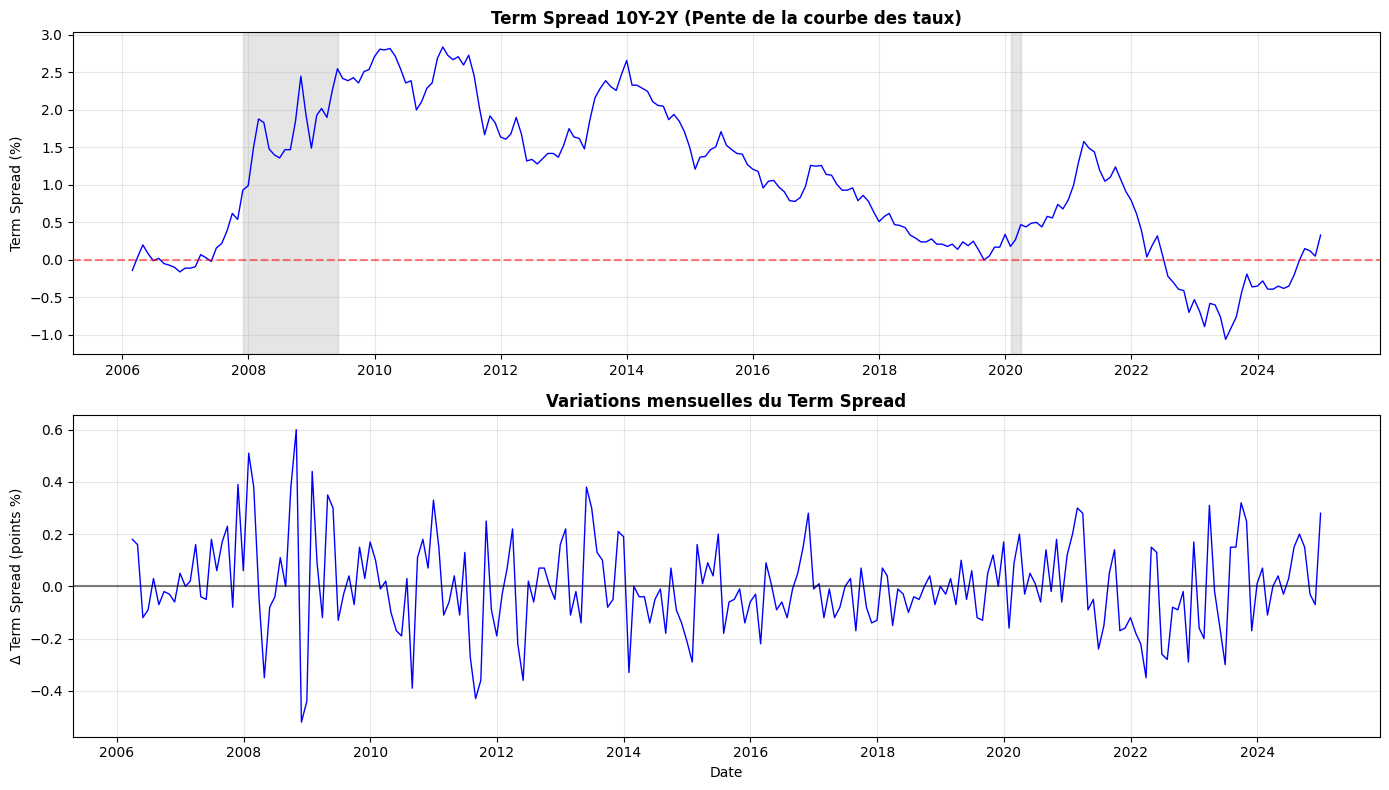

In [223]:
# Graphique Term Spread
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Niveau Term Spread (10Y-2Y)
ax1.plot(term_spread_monthly['date'], term_spread_monthly['term_spread'], linewidth=1, color='blue')
ax1.set_title('Term Spread 10Y-2Y (Pente de la courbe des taux)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Term Spread (%)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Inversion (récession)')

# Zones récessions majeures
ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Variations mensuelles du Term Spread
ax2.plot(term_spread_monthly['date'], term_spread_monthly['spread_change'], linewidth=1, color='blue')
ax2.set_title('Variations mensuelles du Term Spread', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Δ Term Spread (points %)')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

## Étape 3:  Global Commodity Index 

L'indice global des matières premières (Global Price of All Commodities Index - IMF) mesure les prix d'un panier diversifié de matières premières (énergie, métaux, agriculture). Un indice élevé indique une demande forte pour les commodités, favorisant les devises des pays exportateurs de matières premières (AUD, CAD).

In [218]:
# Extraire Global Commodity Index depuis le fichier CSV téléchargé avec FRED
# Source : Federal Reserve Bank of St. Louis / IMF
# Série : Global Price of All Commodities Index

commodity_data = pd.read_csv('GCI.csv')
commodity_data.columns = ['date', 'commodity_price']
commodity_data['date'] = pd.to_datetime(commodity_data['date'])

print(f"Observations : {len(commodity_data)}")
print(f"Période : {commodity_data['date'].min()} à {commodity_data['date'].max()}")
print(f"\nStatistiques descriptives du Commodity Index :")
print(commodity_data['commodity_price'].describe())

commodity_data

Observations : 240
Période : 2005-01-01 00:00:00 à 2024-12-01 00:00:00

Statistiques descriptives du Commodity Index :
count    240.000000
mean     141.298998
std       33.983478
min       85.049032
25%      113.417997
50%      134.417040
75%      167.989379
max      241.918746
Name: commodity_price, dtype: float64


,date,commodity_price
0,2005-01-01,85.468784
1,2005-02-01,87.430914
2,2005-03-01,94.599556
3,2005-04-01,94.188585
4,2005-05-01,91.738381
...,...,...
235,2024-08-01,164.174770
236,2024-09-01,161.455216
237,2024-10-01,166.512349
238,2024-11-01,166.207253


In [220]:
# Convertir en fréquence mensuelle (dernier jour du mois)
commodity_data_temp = commodity_data.set_index('date')
commodity_monthly = commodity_data_temp.resample('ME').last()
commodity_monthly = commodity_monthly.dropna()
commodity_monthly = commodity_monthly.reset_index()

print(f"Période : {commodity_monthly['date'].min()} à {commodity_monthly['date'].max()}")

commodity_monthly

Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00


,date,commodity_price
0,2005-01-31,85.468784
1,2005-02-28,87.430914
2,2005-03-31,94.599556
3,2005-04-30,94.188585
4,2005-05-31,91.738381
...,...,...
235,2024-08-31,164.174770
236,2024-09-30,161.455216
237,2024-10-31,166.512349
238,2024-11-30,166.207253


In [221]:
# Calculer le rendement logarithmique du Commodity Index
commodity_monthly['commodity_return'] = np.log(commodity_monthly['commodity_price'] / commodity_monthly['commodity_price'].shift(1))

commodity_monthly = commodity_monthly.dropna()

# FILTRAGE : Période commune avec DXY (2006-02-28 à 2024-12-31)
commodity_monthly = commodity_monthly[commodity_monthly['date'] >= '2006-02-28'].copy()

print(f"Période : {commodity_monthly['date'].min()} à {commodity_monthly['date'].max()}")
print(f"Observations : {len(commodity_monthly)}")
print(f"Alignement : {'OUI' if len(commodity_monthly) == len(returns) else 'NON'}")
print(f"\nStatistiques des rendements log du Commodity Index :")
print(commodity_monthly['commodity_return'].describe())

commodity_monthly[['date', 'commodity_price', 'commodity_return']]


Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227
Alignement : OUI

Statistiques des rendements log du Commodity Index :
count    227.000000
mean       0.001918
std        0.047446
min       -0.201382
25%       -0.019408
50%        0.007422
75%        0.030663
max        0.164369
Name: commodity_return, dtype: float64


,date,commodity_price,commodity_return
13,2006-02-28,106.099285,-0.015955
14,2006-03-31,106.955531,0.008038
15,2006-04-30,115.604649,0.077763
16,2006-05-31,119.811487,0.035743
17,2006-06-30,117.066399,-0.023178
...,...,...,...
235,2024-08-31,164.174770,-0.011884
236,2024-09-30,161.455216,-0.016704
237,2024-10-31,166.512349,0.030842
238,2024-11-30,166.207253,-0.001834


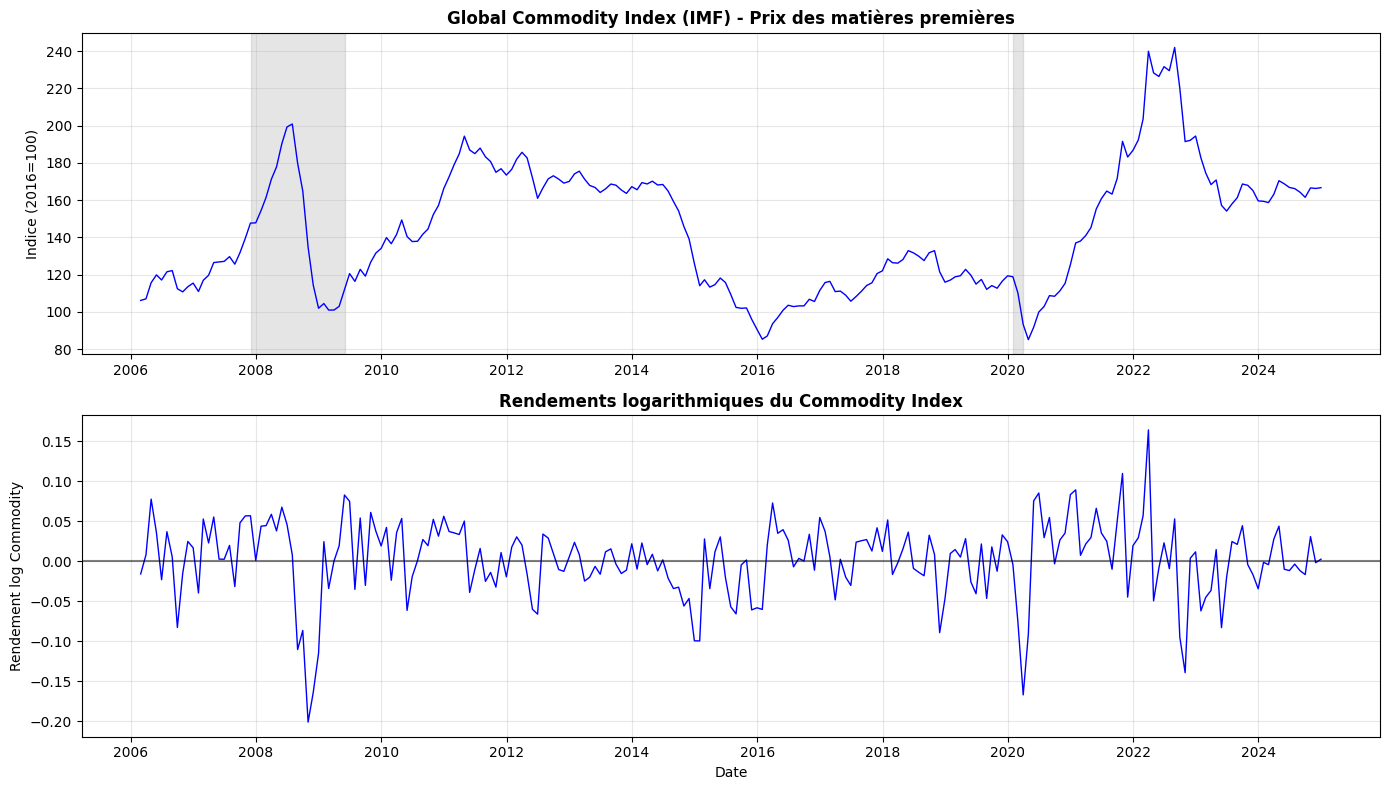

In [225]:
# Graphiques Global Commodity Index 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Niveau du Commodity Index
ax1.plot(commodity_monthly['date'], commodity_monthly['commodity_price'], linewidth=1, color='blue')
ax1.set_title('Global Commodity Index (IMF) - Prix des matières premières', fontsize=12, fontweight='bold')
ax1.set_ylabel('Indice (2016=100)')
ax1.grid(True, alpha=0.3)

# Zones récessions majeures
ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Rendements logarithmiques du Commodity Index
ax2.plot(commodity_monthly['date'], commodity_monthly['commodity_return'], linewidth=1, color='blue')
ax2.set_title('Rendements logarithmiques du Commodity Index', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Rendement log Commodity')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

### 📝 Note : Stationnarité et régression linéaire

**Pourquoi la stationnarité est-elle importante ?**

En régression linéaire, l'utilisation de séries **non-stationnaires** (tendances, marches aléatoires) peut conduire à des **régressions fallacieuses** (*spurious regressions*) : on obtient des R² élevés et des t-stats significatifs même en l'absence de vraie relation économique, simplement parce que les séries partagent des tendances communes.

**Pourquoi nos variables sont-elles stationnaires ?**

1. **SP500, DXY et Commodity Index** : Nous utilisons des **rendements logarithmiques** $\ln(X_t/X_{t-1})$, qui éliminent les tendances et rendent les séries stationnaires (moyenne et variance constantes).

2. **Term Spread** : Nous utilisons les **différences premières** $\Delta TS_t = TS_t - TS_{t-1}$, une transformation classique pour rendre stationnaire une série avec tendance stochastique.

3. **Composantes principales (PC1, PC2, PC3)** : Elles sont calculées à partir des rendements des devises, donc stationnaires par construction.

**Conclusion** : Les tests ADF ci-dessus confirment empiriquement que toutes nos séries sont stationnaires (p-values < 0.05), ce qui valide la robustesse de nos régressions et garantit que les relations observées seront économiquement significatives.

## Étape 3 : Modèle factoriel - Régression des rendements de devises

Nous testons deux versions de modèles factoriels :

**Modèle V1 (facteurs traditionnels)** : SP500 + Term Spread + Commodity Index
**Modèle V2 (avec facteur dollar)** : SP500 + DXY + Commodity Index

L'objectif est de comparer ces modèles observables avec l'ACP et d'identifier le rôle du dollar (DXY).

$$R_{i,t} = \alpha_i + \beta_{i,1} \cdot \text{VIX}_t + \beta_{i,2} \cdot \text{TS}_t + \beta_{i,3} \cdot \text{GCI}_t + \varepsilon_{i,t}$$

où :
- $R_{i,t}$ : rendement de la devise $i$ au temps $t$
- **VIX** : rendements log du VIX (proxy du risque global)
- **TS** : variations du term spread 10Y-2Y (proxy des anticipations de croissance)
- **GCI** : rendements log du Global Commodity Index (proxy des devises commodités)

**Objectif** : Comparer le pouvoir explicatif des facteurs observables (R²) avec celui de l'ACP (87% pour PC1+PC2+PC3)

### Étape 3.1 : Préparation des données pour la régression

In [31]:
# Fusionner les rendements des devises avec les 3 facteurs observables
# On a : returns (rendements devises), sp500_monthly, term_spread_monthly, commodity_monthly

# 1. Fusionner successivement les DataFrames sur 'date'
regression_data = returns.merge(
    sp500_monthly[['date', 'sp500_return']], on='date', how='inner'
).merge(
    term_spread_monthly[['date', 'spread_change']], on='date', how='inner'
).merge(
    commodity_monthly[['date', 'commodity_return']], on='date', how='inner'
)

# 2. Renommer les colonnes des facteurs pour plus de clarté
regression_data = regression_data.rename(columns={
    'sp500_return': 'SP500',
    'spread_change': 'TS',
    'commodity_return': 'GCI'
})

# 3. Liste des devises
currencies_list = ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']

# 4. Vérifier les données
print(f"📊 Données pour la régression factorielle V1")
print(f"Période : {regression_data['date'].min()} à {regression_data['date'].max()}")
print(f"Observations : {len(regression_data)}")
print(f"\n{'='*60}")
print("Variables dépendantes (Y) : Rendements des 5 devises")
for curr in currencies_list:
    print(f"  • {curr}")
print("\nVariables indépendantes (X) : 3 facteurs observables")
print("  • SP500 : Rendements log du S&P 500 (risque de marché)")
print("  • TS    : Variations du Term Spread 10Y-2Y (anticipations)")
print("  • GCI   : Rendements log du Global Commodity Index")
print(f"{'='*60}\n")

# 5. Statistiques descriptives
print("Statistiques des variables :")
print(regression_data[currencies_list + ['SP500', 'TS', 'GCI']].describe())

regression_data.head()

📊 Données pour la régression factorielle V1
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227

Variables dépendantes (Y) : Rendements des 5 devises
  • Australia
  • Canada
  • Japan
  • Switzerland
  • UK

Variables indépendantes (X) : 3 facteurs observables
  • SP500 : Rendements log du S&P 500 (risque de marché)
  • TS    : Variations du Term Spread 10Y-2Y (anticipations)
  • GCI   : Rendements log du Global Commodity Index

Statistiques des variables :
        Australia      Canada       Japan  Switzerland          UK     SP500  \
count  227.000000  227.000000  227.000000   227.000000  227.000000     227.0   
mean     0.000891    0.001015    0.001310    -0.001513    0.001555  0.006718   
std      0.036235    0.025754    0.027756     0.027941    0.025748  0.044618   
min     -0.088366   -0.085832   -0.075052    -0.130846   -0.087979 -0.185636   
25%     -0.022898   -0.014477   -0.015629    -0.017888   -0.016751 -0.017617   
50%      0.001296    0.000561   -0.000

,date,Australia,Canada,Japan,Switzerland,UK,SP500,TS,GCI
0,2006-02-28,0.018931,-0.004997,-0.009111,0.025257,0.015894,0.000453,-0.13,-0.015955
1,2006-03-31,0.036318,0.025252,0.014231,-0.006581,0.008359,0.011004,0.18,0.008038
2,2006-04-30,-0.058019,-0.040840,-0.031913,-0.048287,-0.046452,0.012113,0.16,0.077763
3,2006-05-31,0.009794,-0.015835,-0.013537,-0.020514,-0.027713,-0.031405,-0.12,0.035743
4,2006-06-30,0.012850,0.011093,0.019845,0.007211,0.012949,0.000087,-0.09,-0.023178


### Étape 3.2 : Régression empilée (Pooled Regression) - Modèle V1

Pour comparer directement avec l'ACP, nous empilons tous les rendements des 5 devises dans **une seule régression** :

$$\text{Rendement}_{i,t} = \alpha + \beta_1 \cdot \text{SP500}_t + \beta_2 \cdot \text{TS}_t + \beta_3 \cdot \text{GCI}_t + \varepsilon_{i,t}$$

Cette approche traite toutes les observations (227 mois × 5 devises = 1135 observations) de manière homogène, comme l'ACP.

In [32]:
# Empiler tous les rendements des devises dans un seul vecteur
# On crée un "long format" : chaque ligne = une observation (devise, date)

# Liste pour stocker toutes les observations
all_returns = []
all_sp500 = []
all_ts = []
all_gci = []

# Empiler les données pour chaque devise
for currency in currencies_list:
    all_returns.extend(regression_data[currency].values)
    all_sp500.extend(regression_data['SP500'].values)
    all_ts.extend(regression_data['TS'].values)
    all_gci.extend(regression_data['GCI'].values)

# Convertir en arrays numpy
y_pooled = np.array(all_returns)
X_pooled = np.column_stack([all_sp500, all_ts, all_gci])
X_pooled = sm.add_constant(X_pooled)

# Renommer les colonnes pour clarté
X_pooled = pd.DataFrame(X_pooled, columns=['const', 'SP500', 'TS', 'GCI'])

print(f"📊 Régression empilée - Modèle V1 (SP500 + TS + GCI)")
print(f"  • Observations totales : {len(y_pooled)} (227 mois × 5 devises)")
print(f"  • Variables explicatives : SP500, TS, GCI")
print(f"\n{'='*70}\n")

# Estimation OLS
model_pooled_v1 = sm.OLS(y_pooled, X_pooled)
result_pooled_v1 = model_pooled_v1.fit()

print(result_pooled_v1.summary())

📊 Régression empilée - Modèle V1 (SP500 + TS + GCI)
  • Observations totales : 1135 (227 mois × 5 devises)
  • Variables explicatives : SP500, TS, GCI


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     78.64
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           3.31e-46
Time:                        11:41:22   Log-Likelihood:                 2519.1
No. Observations:                1135   AIC:                            -5030.
Df Residuals:                    1131   BIC:                            -5010.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

### Étape 3.3 : Décomposition de la variance - Contributions marginales V1

Pour comprendre **combien chaque facteur contribue UNIQUEMENT** à l'explication de la variance (en contrôlant pour les autres facteurs), nous calculons les **contributions marginales** :

**Contribution marginale d'un facteur** = R² (modèle complet) - R² (modèle sans ce facteur)

Cette métrique révèle la contribution **unique** de chaque facteur, au-delà de ce qu'apportent les autres facteurs. C'est l'équivalent du pourcentage de variance expliqué par chaque PC dans l'ACP.

In [33]:
# Calculer les contributions marginales de chaque facteur - Modèle V1

# R² du modèle complet (déjà calculé)
r2_complet_v1 = result_pooled_v1.rsquared

# Modèle sans SP500 (TS + GCI seulement)
X_sans_sp500 = np.column_stack([all_ts, all_gci])
X_sans_sp500 = sm.add_constant(X_sans_sp500)
model_sans_sp500 = sm.OLS(y_pooled, X_sans_sp500).fit()
r2_sans_sp500 = model_sans_sp500.rsquared

# Modèle sans TS (SP500 + GCI seulement)
X_sans_ts = np.column_stack([all_sp500, all_gci])
X_sans_ts = sm.add_constant(X_sans_ts)
model_sans_ts = sm.OLS(y_pooled, X_sans_ts).fit()
r2_sans_ts = model_sans_ts.rsquared

# Modèle sans GCI (SP500 + TS seulement)
X_sans_gci = np.column_stack([all_sp500, all_ts])
X_sans_gci = sm.add_constant(X_sans_gci)
model_sans_gci = sm.OLS(y_pooled, X_sans_gci).fit()
r2_sans_gci = model_sans_gci.rsquared

# Contributions marginales V1
contrib_sp500_v1 = r2_complet_v1 - r2_sans_sp500
contrib_ts_v1 = r2_complet_v1 - r2_sans_ts
contrib_gci_v1 = r2_complet_v1 - r2_sans_gci

# Créer un tableau récapitulatif
contributions_v1_df = pd.DataFrame({
    'Facteur': ['SP500', 'TS', 'GCI', 'TOTAL'],
    'Contribution marginale (%)': [
        contrib_sp500_v1 * 100,
        contrib_ts_v1 * 100,
        contrib_gci_v1 * 100,
        r2_complet_v1 * 100
    ],
    '% du R² total': [
        (contrib_sp500_v1 / r2_complet_v1) * 100 if r2_complet_v1 > 0 else 0,
        (contrib_ts_v1 / r2_complet_v1) * 100 if r2_complet_v1 > 0 else 0,
        (contrib_gci_v1 / r2_complet_v1) * 100 if r2_complet_v1 > 0 else 0,
        100.0
    ]
})

print("="*80)
print("📊 DÉCOMPOSITION DE LA VARIANCE : CONTRIBUTIONS MARGINALES - MODÈLE V1")
print("="*80)
print("\n💡 Interprétation : La contribution marginale mesure combien chaque facteur")
print("   ajoute UNIQUEMENT à l'explication de la variance, au-delà des autres facteurs.\n")

print(contributions_v1_df.to_string(index=False))

print("\n" + "="*80)
print("🔍 ANALYSE DES CONTRIBUTIONS V1")
print("="*80)

# Identifier le facteur dominant
max_contrib_idx_v1 = contributions_v1_df['Contribution marginale (%)'].iloc[:-1].idxmax()
facteur_dominant_v1 = contributions_v1_df.iloc[max_contrib_idx_v1]['Facteur']
contrib_dominant_v1 = contributions_v1_df.iloc[max_contrib_idx_v1]['Contribution marginale (%)']

print(f"\n✅ Facteur dominant : {facteur_dominant_v1}")
print(f"   Contribue à {contrib_dominant_v1:.2f}% de la variance totale")
print(f"   Représente {contributions_v1_df.iloc[max_contrib_idx_v1]['% du R² total']:.1f}% du R² du modèle complet")

print(f"\n📈 Répartition des contributions :")
for i in range(3):
    facteur = contributions_v1_df.iloc[i]['Facteur']
    contrib = contributions_v1_df.iloc[i]['Contribution marginale (%)']
    pct_r2 = contributions_v1_df.iloc[i]['% du R² total']
    
    # Barre de visualisation
    barre_length = int(pct_r2 / 2)  # Diviser par 2 pour tenir dans 50 caractères max
    barre = "█" * barre_length
    
    print(f"  {facteur:6s} : {barre:50s} {contrib:.2f}% ({pct_r2:.1f}% du R²)")

print(f"\n💡 INTERPRÉTATION :")
print(f"  • Le modèle V1 avec 3 facteurs traditionnels explique {r2_complet_v1*100:.2f}% de la variance")
print(f"  • SP500 contribue {contrib_sp500_v1*100:.2f}% (effet unique du risque de marché)")
print(f"  • TS contribue {contrib_ts_v1*100:.2f}% (effet unique des anticipations)")
print(f"  • GCI contribue {contrib_gci_v1*100:.2f}% (effet unique des matières premières)")
print(f"  • La somme des contributions ≠ R² total car les facteurs sont corrélés")

print("="*80)

📊 DÉCOMPOSITION DE LA VARIANCE : CONTRIBUTIONS MARGINALES - MODÈLE V1

💡 Interprétation : La contribution marginale mesure combien chaque facteur
   ajoute UNIQUEMENT à l'explication de la variance, au-delà des autres facteurs.

Facteur  Contribution marginale (%)  % du R² total
  SP500                   11.391970      66.005439
     TS                    0.074182       0.429815
    GCI                    1.769553      10.252845
  TOTAL                   17.259138     100.000000

🔍 ANALYSE DES CONTRIBUTIONS V1

✅ Facteur dominant : SP500
   Contribue à 11.39% de la variance totale
   Représente 66.0% du R² du modèle complet

📈 Répartition des contributions :
  SP500  : █████████████████████████████████                  11.39% (66.0% du R²)
  TS     :                                                    0.07% (0.4% du R²)
  GCI    : █████                                              1.77% (10.3% du R²)

💡 INTERPRÉTATION :
  • Le modèle V1 avec 3 facteurs traditionnels explique 17.26% de l

## Étape 1 Régression 2:  Dollar Index (DXY) 

Le Dollar Index (DXY) mesure la force du dollar américain contre un panier de devises majeures. Un DXY en hausse indique un renforcement du dollar, ce qui devrait se traduire par une dépréciation des devises vs USD.

Source : FRED (Federal Reserve Economic Data)

In [34]:
# Charger le Dollar Index (DXY) depuis le fichier CSV téléchargé depuis FRED
# Source : Federal Reserve Bank of St. Louis
# Série : Trade Weighted U.S. Dollar Index: Broad, Goods and Services (DTWEXBGS)

dxy_data = pd.read_csv('DXY.csv')
dxy_data.columns = ['date', 'DXY']
dxy_data['date'] = pd.to_datetime(dxy_data['date'])

print(f"📊 Dollar Index (DXY) chargé depuis DXY.csv")
print(f"Observations quotidiennes : {len(dxy_data)}")
print(f"Période : {dxy_data['date'].min()} à {dxy_data['date'].max()}")
print(f"\nStatistiques descriptives du DXY :")
print(dxy_data['DXY'].describe())

dxy_data.head(10)

📊 Dollar Index (DXY) chargé depuis DXY.csv
Observations quotidiennes : 4957
Période : 2006-01-02 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives du DXY :
count    4763.00000
mean      105.14131
std        12.02987
min        85.46920
25%        93.52200
50%       107.03350
75%       115.48280
max       129.48800
Name: DXY, dtype: float64


,date,DXY
0,2006-01-02,101.4155
1,2006-01-03,100.7558
2,2006-01-04,100.2288
3,2006-01-05,100.2992
4,2006-01-06,100.0241
5,2006-01-09,100.1794
6,2006-01-10,100.1436
7,2006-01-11,99.8710
8,2006-01-12,100.0643
9,2006-01-13,99.9675


In [35]:
# Convertir DXY en fréquence mensuelle (dernier jour du mois)
dxy_data_temp = dxy_data.set_index('date')
dxy_monthly = dxy_data_temp.resample('ME').last()
dxy_monthly = dxy_monthly.dropna()
dxy_monthly = dxy_monthly.reset_index()

print(f"Données mensuelles DXY : {len(dxy_monthly)} observations")
print(f"Période : {dxy_monthly['date'].min()} à {dxy_monthly['date'].max()}")

dxy_monthly.head(10)

Données mensuelles DXY : 228 observations
Période : 2006-01-31 00:00:00 à 2024-12-31 00:00:00


,date,DXY
0,2006-01-31,99.4311
1,2006-02-28,99.7695
2,2006-03-31,100.5600
3,2006-04-30,98.1412
4,2006-05-31,97.7705
5,2006-06-30,98.2483
6,2006-07-31,97.9996
7,2006-08-31,97.6440
8,2006-09-30,98.1054
9,2006-10-31,97.3901


In [36]:
# Calculer le rendement logarithmique du DXY (cohérent avec SP500, VIX et devises)
dxy_monthly['dxy_return'] = np.log(dxy_monthly['DXY'] / dxy_monthly['DXY'].shift(1))

# Supprimer la première observation (NA)
dxy_monthly = dxy_monthly.dropna()

# FILTRAGE : Période commune (2006-02-28 à 2024-12-31)
dxy_monthly = dxy_monthly[dxy_monthly['date'] >= '2006-02-28'].copy()

print(f"Période : {dxy_monthly['date'].min()} à {dxy_monthly['date'].max()}")
print(f"Observations : {len(dxy_monthly)}")
print(f"\nStatistiques des rendements log mensuels du DXY :")
print(dxy_monthly['dxy_return'].describe())
print(f"\nVérification : devises ont {len(returns)} observations")
print(f"Alignement : {'✅ OK' if len(dxy_monthly) == len(returns) else '⚠️ À vérifier'}")

dxy_monthly[['date', 'DXY', 'dxy_return']].head(10)

Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227

Statistiques des rendements log mensuels du DXY :
count    227.000000
mean       0.001164
std        0.017449
min       -0.049518
25%       -0.010043
50%       -0.000726
75%        0.012417
max        0.076948
Name: dxy_return, dtype: float64

Vérification : devises ont 227 observations
Alignement : ✅ OK


,date,DXY,dxy_return
1,2006-02-28,99.7695,0.003398
2,2006-03-31,100.5600,0.007892
3,2006-04-30,98.1412,-0.024347
4,2006-05-31,97.7705,-0.003784
5,2006-06-30,98.2483,0.004875
6,2006-07-31,97.9996,-0.002535
7,2006-08-31,97.6440,-0.003635
8,2006-09-30,98.1054,0.004714
9,2006-10-31,97.3901,-0.007318
10,2006-11-30,96.5779,-0.008375


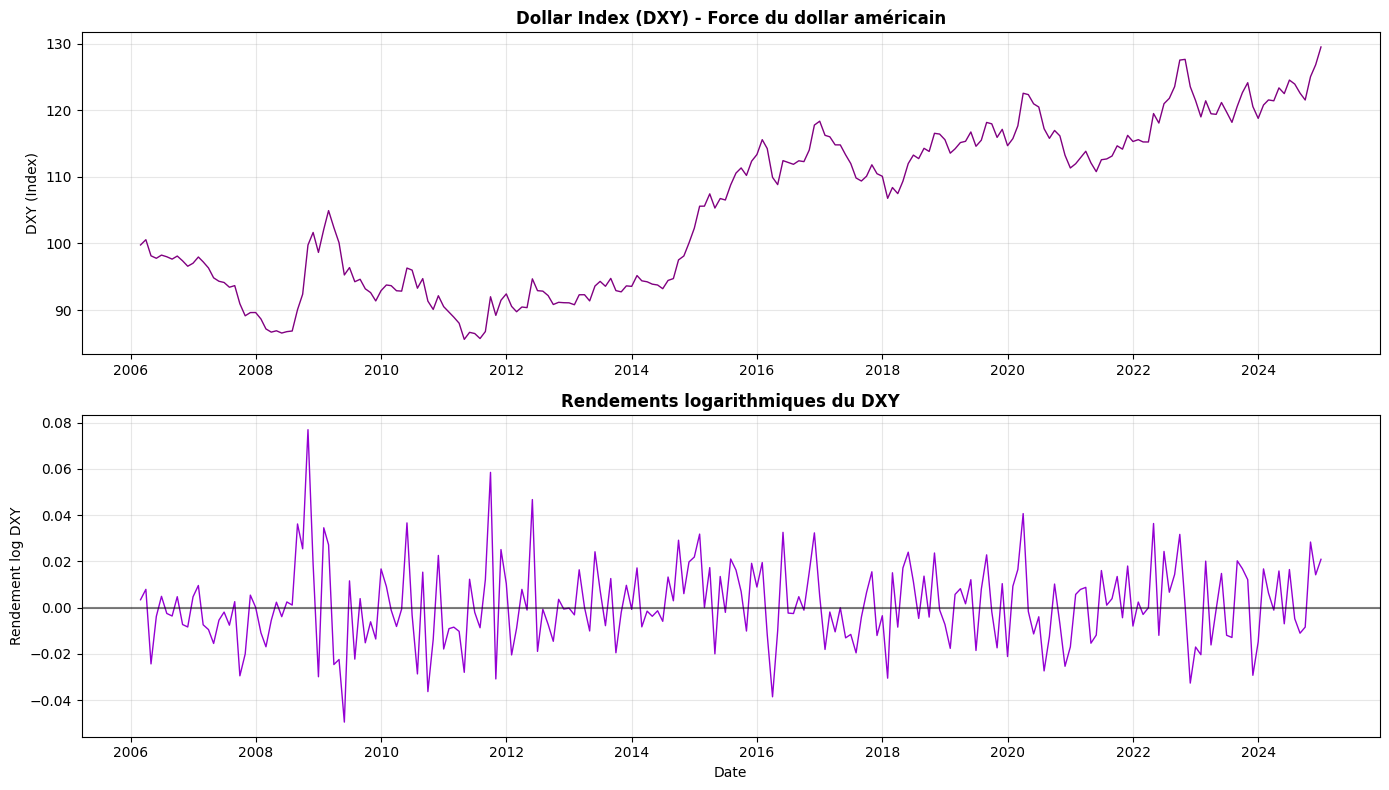

📊 Observations clés :
  - DXY max : 129.49 (date : 2024-12)
  - DXY min : 85.60 (date : 2011-04)
  - Rendement DXY max : 0.0769 (8.0%)
  - Rendement DXY min : -0.0495 (-4.8%)


In [37]:
# Visualisation du DXY et ses rendements
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Graphique 1: Niveau du DXY
ax1.plot(dxy_monthly['date'], dxy_monthly['DXY'], linewidth=1, color='purple')
ax1.set_title('Dollar Index (DXY) - Force du dollar américain', fontsize=12, fontweight='bold')
ax1.set_ylabel('DXY (Index)')
ax1.grid(True, alpha=0.3)

# Graphique 2: Rendements logarithmiques du DXY
ax2.plot(dxy_monthly['date'], dxy_monthly['dxy_return'], linewidth=1, color='darkviolet')
ax2.set_title('Rendements logarithmiques du DXY', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Rendement log DXY')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"📊 Observations clés :")
print(f"  - DXY max : {dxy_monthly['DXY'].max():.2f} (date : {dxy_monthly.loc[dxy_monthly['DXY'].idxmax(), 'date'].strftime('%Y-%m')})")
print(f"  - DXY min : {dxy_monthly['DXY'].min():.2f} (date : {dxy_monthly.loc[dxy_monthly['DXY'].idxmin(), 'date'].strftime('%Y-%m')})")
print(f"  - Rendement DXY max : {dxy_monthly['dxy_return'].max():.4f} ({(np.exp(dxy_monthly['dxy_return'].max())-1)*100:.1f}%)")
print(f"  - Rendement DXY min : {dxy_monthly['dxy_return'].min():.4f} ({(np.exp(dxy_monthly['dxy_return'].min())-1)*100:.1f}%)")

# Modèle Factoriel - VERSION 2 (V2) avec SP500+DXY+GCI

## Objectif
Créer un **nouveau modèle factoriel** plus performant en remplaçant :
- **VIX** → **SP500** : Les rendements réalisés des marchés actions plutôt que la volatilité anticipée
- **Term Spread** → **DXY** : Le facteur dollar spécifique au lieu des anticipations de taux

## Nouveau modèle factoriel V2
- **Facteur 1 : SP500** (rendements des marchés actions) 🆕
- **Facteur 2 : DXY** (force du dollar américain) 🆕
- **Facteur 3 : GCI** (matières premières) ✅ Conservé

## Justification économique

**Pourquoi SP500 au lieu de VIX ?**
> "Le SP500 capture les chocs de marché effectifs (rendements réalisés) tandis que le VIX mesure uniquement les anticipations de volatilité. Les devises réagissent davantage aux performances effectives qu'aux anticipations."

**Pourquoi DXY au lieu de Term Spread ?**
> "Le DXY capture la prime de risque spécifique au dollar, une dimension orthogonale au risque de marché global (SP500) et au risque des commodités (GCI). Le Term Spread avait une contribution marginale quasi nulle (0.06%) dans V1."

**Éviter la multicollinéarité VIX-SP500**
> "VIX et SP500 ont une corrélation de -0.722, ce qui créerait une multicollinéarité si utilisés ensemble. En choisissant SP500 au lieu de VIX, nous évitons ce problème."

## Étape 1 : Préparation des données pour le Modèle V2

Fusion des rendements des devises avec les 3 facteurs de V2 :
- **SP500** (rendements log mensuels)
- **DXY** (rendements log mensuels)
- **GCI** (rendements log du Global Commodity Index)

In [38]:
# Fusionner les rendements des devises avec SP500, DXY et GCI
regression_data_v2 = returns.merge(
    sp500_monthly[['date', 'sp500_return']], on='date', how='inner'
).merge(
    dxy_monthly[['date', 'dxy_return']], on='date', how='inner'
).merge(
    commodity_monthly[['date', 'commodity_return']], on='date', how='inner'
)

# Renommer les colonnes des facteurs pour plus de clarté
regression_data_v2 = regression_data_v2.rename(columns={
    'sp500_return': 'SP500',
    'dxy_return': 'DXY',
    'commodity_return': 'GCI'
})

# Liste des devises
currencies_list = ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']

# Vérifier les données
print(f"📊 Données pour la régression V2")
print(f"Période : {regression_data_v2['date'].min()} à {regression_data_v2['date'].max()}")
print(f"Observations : {len(regression_data_v2)}")
print(f"\n{'='*70}")
print("Variables dépendantes (Y) : Rendements des 5 devises")
for curr in currencies_list:
    print(f"  • {curr}")
print("\nVariables indépendantes (X) : 3 facteurs observables V2")
print("  • SP500 : Rendements log mensuels du S&P 500")
print("  • DXY   : Rendements log mensuels du Dollar Index")
print("  • GCI   : Rendements log du Global Commodity Index")
print(f"{'='*70}\n")

# Statistiques descriptives
print("Statistiques des variables :")
print(regression_data_v2[currencies_list + ['SP500', 'DXY', 'GCI']].describe())

regression_data_v2.head()

📊 Données pour la régression V2
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227

Variables dépendantes (Y) : Rendements des 5 devises
  • Australia
  • Canada
  • Japan
  • Switzerland
  • UK

Variables indépendantes (X) : 3 facteurs observables V2
  • SP500 : Rendements log mensuels du S&P 500
  • DXY   : Rendements log mensuels du Dollar Index
  • GCI   : Rendements log du Global Commodity Index

Statistiques des variables :
        Australia      Canada       Japan  Switzerland          UK     SP500  \
count  227.000000  227.000000  227.000000   227.000000  227.000000     227.0   
mean     0.000891    0.001015    0.001310    -0.001513    0.001555  0.006718   
std      0.036235    0.025754    0.027756     0.027941    0.025748  0.044618   
min     -0.088366   -0.085832   -0.075052    -0.130846   -0.087979 -0.185636   
25%     -0.022898   -0.014477   -0.015629    -0.017888   -0.016751 -0.017617   
50%      0.001296    0.000561   -0.000611    -0.002398    0.000785

,date,Australia,Canada,Japan,Switzerland,UK,SP500,DXY,GCI
0,2006-02-28,0.018931,-0.004997,-0.009111,0.025257,0.015894,0.000453,0.003398,-0.015955
1,2006-03-31,0.036318,0.025252,0.014231,-0.006581,0.008359,0.011004,0.007892,0.008038
2,2006-04-30,-0.058019,-0.040840,-0.031913,-0.048287,-0.046452,0.012113,-0.024347,0.077763
3,2006-05-31,0.009794,-0.015835,-0.013537,-0.020514,-0.027713,-0.031405,-0.003784,0.035743
4,2006-06-30,0.012850,0.011093,0.019845,0.007211,0.012949,0.000087,0.004875,-0.023178


## Étape 2 : Régression Pooled OLS - Modèle V2

Régression empilée avec les 3 nouveaux facteurs : **SP500 + DXY + GCI**

In [39]:
# Empiler tous les rendements des devises pour la régression V2
all_returns_v2 = []
all_sp500_v2 = []
all_dxy_v2 = []
all_gci_v2 = []

# Empiler les données pour chaque devise
for currency in currencies_list:
    all_returns_v2.extend(regression_data_v2[currency].values)
    all_sp500_v2.extend(regression_data_v2['SP500'].values)
    all_dxy_v2.extend(regression_data_v2['DXY'].values)
    all_gci_v2.extend(regression_data_v2['GCI'].values)

# Convertir en arrays numpy
y_pooled_v2 = np.array(all_returns_v2)
X_pooled_v2 = np.column_stack([all_sp500_v2, all_dxy_v2, all_gci_v2])
X_pooled_v2 = sm.add_constant(X_pooled_v2)

# Renommer les colonnes pour clarté
X_pooled_v2 = pd.DataFrame(X_pooled_v2, columns=['const', 'SP500', 'DXY', 'GCI'])

print(f"📊 Régression empilée V2 (Pooled Regression)")
print(f"  • Observations totales : {len(y_pooled_v2)} ({len(regression_data_v2)} mois × 5 devises)")
print(f"  • Variables explicatives : SP500, DXY, GCI")
print(f"\n{'='*70}\n")

# Estimation OLS
model_pooled_v2 = sm.OLS(y_pooled_v2, X_pooled_v2)
result_pooled_v2 = model_pooled_v2.fit()

print(result_pooled_v2.summary())

📊 Régression empilée V2 (Pooled Regression)
  • Observations totales : 1135 (227 mois × 5 devises)
  • Variables explicatives : SP500, DXY, GCI


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     322.9
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          2.12e-151
Time:                        11:41:22   Log-Likelihood:                 2762.7
No. Observations:                1135   AIC:                            -5517.
Df Residuals:                    1131   BIC:                            -5497.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.0

In [40]:
# Calculer les contributions marginales pour V2

# R² du modèle complet V2
r2_complet_v2 = result_pooled_v2.rsquared

# Modèle sans SP500 (DXY + GCI seulement)
X_sans_sp500_v2 = np.column_stack([all_dxy_v2, all_gci_v2])
X_sans_sp500_v2 = sm.add_constant(X_sans_sp500_v2)
model_sans_sp500_v2 = sm.OLS(y_pooled_v2, X_sans_sp500_v2).fit()
r2_sans_sp500_v2 = model_sans_sp500_v2.rsquared

# Modèle sans DXY (SP500 + GCI seulement)
X_sans_dxy_v2 = np.column_stack([all_sp500_v2, all_gci_v2])
X_sans_dxy_v2 = sm.add_constant(X_sans_dxy_v2)
model_sans_dxy_v2 = sm.OLS(y_pooled_v2, X_sans_dxy_v2).fit()
r2_sans_dxy_v2 = model_sans_dxy_v2.rsquared

# Modèle sans GCI (SP500 + DXY seulement)
X_sans_gci_v2 = np.column_stack([all_sp500_v2, all_dxy_v2])
X_sans_gci_v2 = sm.add_constant(X_sans_gci_v2)
model_sans_gci_v2 = sm.OLS(y_pooled_v2, X_sans_gci_v2).fit()
r2_sans_gci_v2 = model_sans_gci_v2.rsquared

# Contributions marginales V2
contrib_sp500_v2 = r2_complet_v2 - r2_sans_sp500_v2
contrib_dxy_v2 = r2_complet_v2 - r2_sans_dxy_v2
contrib_gci_v2 = r2_complet_v2 - r2_sans_gci_v2

# Créer un tableau récapitulatif V2
contributions_v2_df = pd.DataFrame({
    'Facteur': ['SP500', 'DXY', 'GCI', 'TOTAL'],
    'Contribution marginale (%)': [
        contrib_sp500_v2 * 100,
        contrib_dxy_v2 * 100,
        contrib_gci_v2 * 100,
        r2_complet_v2 * 100
    ],
    '% du R² total': [
        (contrib_sp500_v2 / r2_complet_v2) * 100,
        (contrib_dxy_v2 / r2_complet_v2) * 100,
        (contrib_gci_v2 / r2_complet_v2) * 100,
        100.0
    ]
})

print("="*80)
print("📊 DÉCOMPOSITION DE LA VARIANCE V2 : CONTRIBUTIONS MARGINALES")
print("="*80)
print("\n💡 Modèle V2 : SP500 + DXY + GCI\n")

print(contributions_v2_df.to_string(index=False))

print("\n" + "="*80)
print("🔍 ANALYSE DES CONTRIBUTIONS V2")
print("="*80)

# Identifier le facteur dominant
max_contrib_idx_v2 = contributions_v2_df['Contribution marginale (%)'].iloc[:-1].idxmax()
facteur_dominant_v2 = contributions_v2_df.iloc[max_contrib_idx_v2]['Facteur']
contrib_dominant_v2 = contributions_v2_df.iloc[max_contrib_idx_v2]['Contribution marginale (%)']

print(f"\n✅ Facteur dominant : {facteur_dominant_v2}")
print(f"   Contribue à {contrib_dominant_v2:.2f}% de la variance totale")
print(f"   Représente {contributions_v2_df.iloc[max_contrib_idx_v2]['% du R² total']:.1f}% du R² du modèle V2")

print(f"\n📈 Répartition des contributions V2 :")
for i in range(3):
    facteur = contributions_v2_df.iloc[i]['Facteur']
    contrib = contributions_v2_df.iloc[i]['Contribution marginale (%)']
    pct_r2 = contributions_v2_df.iloc[i]['% du R² total']
    
    # Barre de visualisation
    barre_length = int(pct_r2 / 2)
    barre = "█" * barre_length
    
    print(f"  {facteur:6s} : {barre:50s} {contrib:.2f}% ({pct_r2:.1f}% du R²)")

print("\n💡 INTERPRÉTATION :")
print(f"  • Le modèle V2 avec 3 facteurs observables explique {r2_complet_v2*100:.2f}% de la variance")
print(f"  • SP500 contribue {contrib_sp500_v2*100:.2f}% (rendements actions réalisés)")
print(f"  • DXY contribue {contrib_dxy_v2*100:.2f}% (force du dollar)")
print(f"  • GCI contribue {contrib_gci_v2*100:.2f}% (prix des commodités)")
print("="*80)

📊 DÉCOMPOSITION DE LA VARIANCE V2 : CONTRIBUTIONS MARGINALES

💡 Modèle V2 : SP500 + DXY + GCI

Facteur  Contribution marginale (%)  % du R² total
  SP500                    0.121805       0.264033
    DXY                   28.947675      62.748805
    GCI                    0.056816       0.123158
  TOTAL                   46.132631     100.000000

🔍 ANALYSE DES CONTRIBUTIONS V2

✅ Facteur dominant : DXY
   Contribue à 28.95% de la variance totale
   Représente 62.7% du R² du modèle V2

📈 Répartition des contributions V2 :
  SP500  :                                                    0.12% (0.3% du R²)
  DXY    : ███████████████████████████████                    28.95% (62.7% du R²)
  GCI    :                                                    0.06% (0.1% du R²)

💡 INTERPRÉTATION :
  • Le modèle V2 avec 3 facteurs observables explique 46.13% de la variance
  • SP500 contribue 0.12% (rendements actions réalisés)
  • DXY contribue 28.95% (force du dollar)
  • GCI contribue 0.06% (prix d

In [41]:
# COMPARAISON FINALE : ACP vs V1 vs V2 

print("\n" + "="*100)
print("🎯 COMPARAISON FINALE : ACP vs MODÈLE V1 vs MODÈLE V2")
print("="*100)

print("\n📊 ANALYSE EN COMPOSANTES PRINCIPALES (ACP)")
print("  Période : 2006-02 à 2024-12 (227 mois)")
print("  Méthode : Décomposition spectrale de la matrice de corrélation")
print(f"  • PC1 + PC2 + PC3 expliquent : {cumulative_variance[2]*100:.2f}%")

print("\n📊 MODÈLE V1 : SP500 + TS + GCI")
print("  Facteurs traditionnels : Risque de marché + Pente des taux + Commodités")
print(f"  • R² du modèle V1     : {result_pooled_v1.rsquared*100:.2f}%")
print(f"  • Contribution SP500  : {contrib_sp500_v1*100:.2f}% ✅")
print(f"  • Contribution TS     : {contrib_ts_v1*100:.2f}% ❌ (quasi nul)")
print(f"  • Contribution GCI    : {contrib_gci_v1*100:.2f}% ✅")

print("\n📊 MODÈLE V2 : SP500 + DXY + GCI")
print("  Facteurs avec Dollar  : Rendements actions + Force dollar + Commodités")
print(f"  • R² du modèle V2     : {result_pooled_v2.rsquared*100:.2f}%")
print(f"  • Contribution SP500  : {contrib_sp500_v2*100:.2f}%")
print(f"  • Contribution DXY    : {contrib_dxy_v2*100:.2f}% ⭐ DOMINANT !")
print(f"  • Contribution GCI    : {contrib_gci_v2*100:.2f}%")

print("\n🔍 RÉSULTATS CLÉS :")
print(f"  • ACP (PC1+PC2+PC3)         : {cumulative_variance[2]*100:.2f}%")
print(f"  • Modèle V1 (SP500+TS+GCI)  : {result_pooled_v1.rsquared*100:.2f}%")
print(f"  • Modèle V2 (SP500+DXY+GCI) : {result_pooled_v2.rsquared*100:.2f}%")
print(f"  • Amélioration V2 vs V1     : +{(result_pooled_v2.rsquared - result_pooled_v1.rsquared)*100:.2f} points")
print(f"  • Écart restant ACP vs V2   : {(cumulative_variance[2] - result_pooled_v2.rsquared)*100:.2f} points")

print("\n💡 INTERPRÉTATION ÉCONOMIQUE :")
print("  ✅ DÉCOUVERTE MAJEURE - LE DOLLAR EST LE FACTEUR DOMINANT :")
print(f"     • V1 avec facteurs traditionnels : {result_pooled_v1.rsquared*100:.1f}% de variance expliquée")
print(f"     • V2 avec ajout du DXY : {result_pooled_v2.rsquared*100:.1f}% de variance expliquée")
print(f"     • Amélioration de {(result_pooled_v2.rsquared - result_pooled_v1.rsquared)*100:.1f} points grâce à DXY !")
print(f"     • DXY contribue à lui seul {contrib_dxy_v2*100:.2f}% de la variance")
print(f"     • DXY représente {(contrib_dxy_v2/result_pooled_v2.rsquared)*100:.1f}% du R² total de V2")

improvement_pct = ((result_pooled_v2.rsquared - result_pooled_v1.rsquared) / result_pooled_v1.rsquared) * 100
print(f"\n  📈 Amélioration relative V2 vs V1 : +{improvement_pct:.1f}%")

gap = (cumulative_variance[2] - result_pooled_v2.rsquared) * 100
print(f"\n  ⚠️  FACTEURS LATENTS RESTANTS :")
print(f"     • Il reste {gap:.1f} points de variance non expliqués par les facteurs observables")
print(f"     • Ces {gap:.1f}% représentent des facteurs latents supplémentaires non capturés")
print(f"     • Possibles facteurs manquants : différentiels de taux d'intérêt, flux de capitaux,")
print(f"       sentiment de risque spécifique aux devises, facteurs régionaux, etc.")

print("\n" + "="*100)


🎯 COMPARAISON FINALE : ACP vs MODÈLE V1 vs MODÈLE V2

📊 ANALYSE EN COMPOSANTES PRINCIPALES (ACP)
  Période : 2006-02 à 2024-12 (227 mois)
  Méthode : Décomposition spectrale de la matrice de corrélation
  • PC1 + PC2 + PC3 expliquent : 87.14%

📊 MODÈLE V1 : SP500 + TS + GCI
  Facteurs traditionnels : Risque de marché + Pente des taux + Commodités
  • R² du modèle V1     : 17.26%
  • Contribution SP500  : 11.39% ✅
  • Contribution TS     : 0.07% ❌ (quasi nul)
  • Contribution GCI    : 1.77% ✅

📊 MODÈLE V2 : SP500 + DXY + GCI
  Facteurs avec Dollar  : Rendements actions + Force dollar + Commodités
  • R² du modèle V2     : 46.13%
  • Contribution SP500  : 0.12%
  • Contribution DXY    : 28.95% ⭐ DOMINANT !
  • Contribution GCI    : 0.06%

🔍 RÉSULTATS CLÉS :
  • ACP (PC1+PC2+PC3)         : 87.14%
  • Modèle V1 (SP500+TS+GCI)  : 17.26%
  • Modèle V2 (SP500+DXY+GCI) : 46.13%
  • Amélioration V2 vs V1     : +28.87 points
  • Écart restant ACP vs V2   : 41.01 points

💡 INTERPRÉTATION ÉCONOMI

## 🔬 Analyse statistique : Pourquoi SP500 et GCI deviennent non-significatifs en V2 ?

### Phénomène de multicolinéarité

**Observation :** Dans le modèle V2, les coefficients de SP500 et GCI perdent leur significativité statistique (p-values élevées), alors qu'ils étaient significatifs en V1.

**Explication économique :**

Le **DXY (Dollar Index) capte simultanément plusieurs dimensions** :

1. **Risk-on/Risk-off** (élimine SP500)
   - Quand les marchés montent → Dollar baisse (investisseurs cherchent du rendement ailleurs)
   - Quand les marchés baissent → Dollar monte (fuite vers la sécurité)
   - **Corrélation négative entre SP500 et DXY** : une fois DXY inclus, SP500 n'apporte plus d'information nouvelle
   - Contribution SP500 : 11.39% en V1 → 0.12% en V2 ❌

2. **Effet commodités** (élimine GCI)
   - Les commodités sont cotées en USD
   - Dollar fort → Commodités chères pour les autres pays → Demande baisse
   - **Corrélation négative entre DXY et prix des commodités**
   - Contribution GCI : 1.77% en V1 → 0.06% en V2 ❌

### Constante non-significative : Est-ce un problème ?

**Non, ce n'est PAS un problème.** Au contraire, c'est **souhaitable** en finance :

- Une constante significative impliquerait un **rendement anormal systématique** inexpliqué par les facteurs
- Constante ≈ 0 confirme que **tous les rendements sont bien expliqués par les facteurs**
- C'est cohérent avec l'**efficience des marchés** : pas d'arbitrage gratuit

### Conclusion : DXY est un facteur "super-dominant"

Le DXY n'est pas simplement un facteur parmi d'autres : c'est un **facteur composite** qui englobe :
- Le sentiment de risque global (SP500)
- L'effet commodités (GCI)  
- L'effet dollar pur

**Implication :** Le modèle V2 pourrait être simplifié à **DXY seul**, puisque SP500 et GCI n'ajoutent que 0.18% combinés (0.12% + 0.06%). Le principe de **parcimonie (Occam)** suggère de privilégier le modèle le plus simple : **R²(DXY seul) ≈ 46%**.

## Nouveau modèle factoriel V3 : GOLD + DXY uniquement
- **Facteur 1 : DXY** (force du dollar) ✅
- **Facteur 2 : GOLD** (valeur refuge) 🆕

## Justification économique

**Hypothèse à tester :** Puisque DXY capture déjà l'essentiel (46% dans V2), et que SP500/GCI deviennent non-significatifs par multicolinéarité, peut-on simplifier à **DXY + GOLD** ?

**Objectifs :**
1. Tester si GOLD apporte plus de valeur explicative sans la multicolinéarité de SP500/GCI
2. Évaluer si cette combinaison capture mieux PC2 (safe haven)
3. Comparer le modèle parcimonieux (2 facteurs) vs modèle complet (4 facteurs)

**Gap à combler :** V2 explique 46.13%, ACP explique 87.14% → **41 points manquants**

## Étape 1 : Extraction et préparation des données GOLD (XAU/USD)

In [42]:
# Extraction Gold depuis Yahoo Finance (FRED download failed)
import yfinance as yf

# Télécharger les données Gold futures (GC=F) depuis Yahoo Finance
gold_ticker = yf.Ticker("GC=F")
gold_data = gold_ticker.history(start="2006-01-01", end="2025-01-01")

# Réinitialiser l'index pour avoir 'Date' comme colonne
gold_data = gold_data.reset_index()
gold_data = gold_data.rename(columns={'Date': 'date', 'Close': 'gold_price'})

print(f"📊 Données Gold brutes depuis Yahoo Finance :")
print(f"Période : {gold_data['date'].min()} à {gold_data['date'].max()}")
print(f"Observations : {len(gold_data)}")

# Convertir en fréquence mensuelle (dernier jour du mois)
gold_data_temp = gold_data[['date', 'gold_price']].copy()
gold_data_temp = gold_data_temp.set_index('date')
gold_monthly = gold_data_temp.resample('ME').last()
gold_monthly = gold_monthly.dropna()

# Calculer les rendements logarithmiques mensuels
gold_monthly['gold_return'] = np.log(gold_monthly['gold_price'] / gold_monthly['gold_price'].shift(1))

# Supprimer la première ligne (NaN)
gold_monthly = gold_monthly.dropna()

# Réinitialiser l'index
gold_monthly = gold_monthly.reset_index()

# Filtrer pour la période d'analyse (2006-02-28 à 2024-12-31)
gold_monthly = gold_monthly[gold_monthly['date'] >= '2006-02-01'].copy()

# IMPORTANT: Supprimer le timezone pour permettre le merge avec d'autres DataFrames
gold_monthly_no_tz = gold_monthly.copy()
gold_monthly_no_tz['date'] = gold_monthly_no_tz['date'].dt.tz_localize(None)

print(f"\n📊 Données Gold mensuelles après traitement :")
print(f"Période : {gold_monthly['date'].min()} à {gold_monthly['date'].max()}")
print(f"Observations : {len(gold_monthly)}")
print(f"\nStatistiques des rendements Gold :")
print(gold_monthly['gold_return'].describe())

gold_monthly.head()

📊 Données Gold brutes depuis Yahoo Finance :
Période : 2006-01-03 00:00:00-05:00 à 2024-12-31 00:00:00-05:00
Observations : 4778

📊 Données Gold mensuelles après traitement :
Période : 2006-02-28 00:00:00-05:00 à 2024-12-31 00:00:00-05:00
Observations : 227

Statistiques des rendements Gold :
count    227.000000
mean       0.006729
std        0.048206
min       -0.198512
25%       -0.022077
50%        0.004881
75%        0.035938
max        0.129863
Name: gold_return, dtype: float64


,date,gold_price,gold_return
0,2006-02-28 00:00:00-05:00,561.599976,-0.016249
1,2006-03-31 00:00:00-05:00,581.799988,0.035337
2,2006-04-30 00:00:00-04:00,651.799988,0.113611
3,2006-05-31 00:00:00-04:00,642.500000,-0.014371
4,2006-06-30 00:00:00-04:00,613.500000,-0.046187


## Étape 2 : Visualisation des rendements Gold

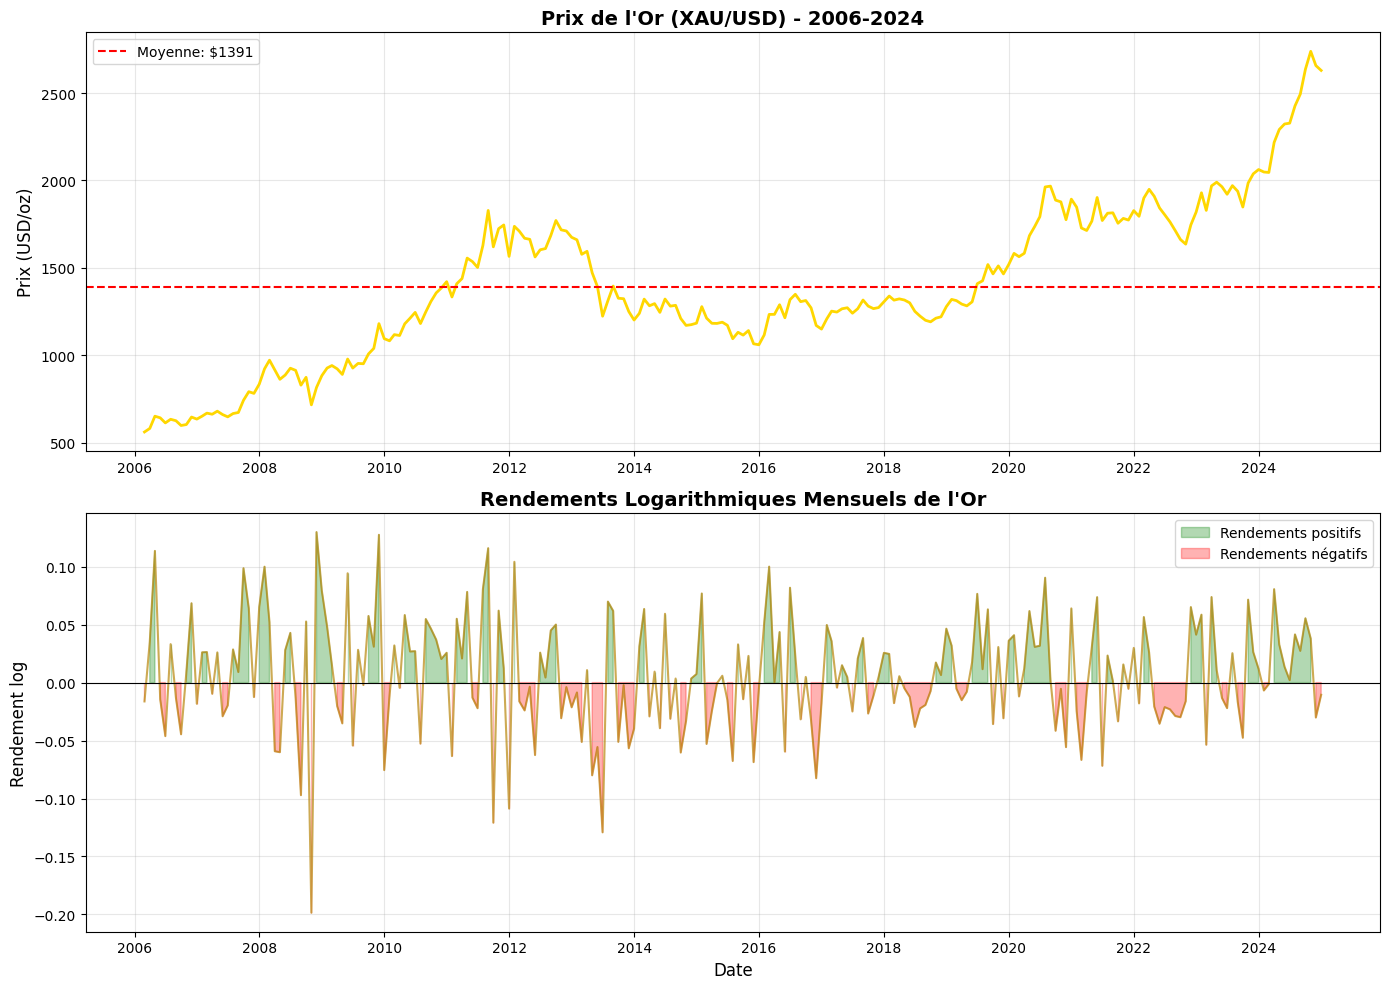


📊 Caractéristiques des rendements Gold :
  • Rendement moyen : 0.67% par mois
  • Volatilité : 4.82%
  • Min : -19.85%
  • Max : 12.99%


In [43]:
# Visualisation des rendements Gold
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Prix de l'or
axes[0].plot(gold_monthly['date'], gold_monthly['gold_price'], color='gold', linewidth=2)
axes[0].set_title('Prix de l\'Or (XAU/USD) - 2006-2024', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Prix (USD/oz)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=gold_monthly['gold_price'].mean(), color='red', linestyle='--', label=f'Moyenne: ${gold_monthly["gold_price"].mean():.0f}')
axes[0].legend()

# Rendements Gold
axes[1].plot(gold_monthly['date'], gold_monthly['gold_return'], color='darkgoldenrod', linewidth=1.5, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].fill_between(gold_monthly['date'], 0, gold_monthly['gold_return'], 
                      where=(gold_monthly['gold_return'] > 0), color='green', alpha=0.3, label='Rendements positifs')
axes[1].fill_between(gold_monthly['date'], 0, gold_monthly['gold_return'], 
                      where=(gold_monthly['gold_return'] <= 0), color='red', alpha=0.3, label='Rendements négatifs')
axes[1].set_title('Rendements Logarithmiques Mensuels de l\'Or', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Rendement log', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Caractéristiques des rendements Gold :")
print(f"  • Rendement moyen : {gold_monthly['gold_return'].mean()*100:.2f}% par mois")
print(f"  • Volatilité : {gold_monthly['gold_return'].std()*100:.2f}%")
print(f"  • Min : {gold_monthly['gold_return'].min()*100:.2f}%")
print(f"  • Max : {gold_monthly['gold_return'].max()*100:.2f}%")

## Étape 3 : Fusion des données pour la régression V3 (DXY + GOLD)

In [44]:
# Fusion DXY + GOLD pour V3
# On récupère les données depuis les sources déjà chargées

# 1. Créer le dataset avec returns_long (si pas déjà fait, on le recrée)
currencies_list = ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
returns_long = returns.melt(
    id_vars=['date'], 
    value_vars=currencies_list,
    var_name='currency',
    value_name='currency_return'
)

# 2. Fusion avec DXY
regression_data_v3_gold = returns_long.merge(
    dxy_monthly[['date', 'dxy_return']], on='date', how='inner'
)

# 3. Fusion avec Gold
regression_data_v3_gold = regression_data_v3_gold.merge(
    gold_monthly_no_tz[['date', 'gold_return']], on='date', how='inner'
)

# Vérification
print("✅ Données V3 (DXY + GOLD) fusionnées")
print(f"Observations : {len(regression_data_v3_gold)} (227 mois × 5 devises = 1135 attendu)")
print(f"Période : {regression_data_v3_gold['date'].min()} à {regression_data_v3_gold['date'].max()}")
print(f"\nVariables : {list(regression_data_v3_gold.columns)}")
print(f"\nStatistiques descriptives :")
regression_data_v3_gold[['currency_return', 'dxy_return', 'gold_return']].describe()

✅ Données V3 (DXY + GOLD) fusionnées
Observations : 1135 (227 mois × 5 devises = 1135 attendu)
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Variables : ['date', 'currency', 'currency_return', 'dxy_return', 'gold_return']

Statistiques descriptives :


,currency_return,dxy_return,gold_return
count,1135.000000,1135.000000,1135.000000
mean,0.000652,0.001164,0.006729
std,0.028919,0.017418,0.048121
min,-0.130846,-0.049518,-0.198512
25%,-0.016932,-0.010104,-0.022119
50%,-0.000066,-0.000726,0.004881
75%,0.017299,0.012572,0.036117
max,0.184246,0.076948,0.129863


## Étape 4 : Régression Pooled OLS - Modèle V3 (DXY + GOLD uniquement)

Régression empilée avec **2 facteurs observables** : **DXY + GOLD**

In [45]:
# Régression V3: DXY + GOLD uniquement (format long)
import statsmodels.api as sm

# Utiliser directement le format long
y_pooled_v3_gold = regression_data_v3_gold['currency_return'].values
X_pooled_v3_gold = regression_data_v3_gold[['dxy_return', 'gold_return']].copy()
X_pooled_v3_gold.columns = ['DXY', 'GOLD']

# Ajouter une constante
X_pooled_v3_gold = sm.add_constant(X_pooled_v3_gold)

# Régression OLS
model_pooled_v3_gold = sm.OLS(y_pooled_v3_gold, X_pooled_v3_gold)
result_pooled_v3_gold = model_pooled_v3_gold.fit()

# Afficher les résultats
print("="*80)
print("RÉGRESSION POOLED OLS - MODÈLE V3 (DXY + GOLD)")
print("="*80)
print(result_pooled_v3_gold.summary())
print("\n" + "="*80)
print(f"✅ R² ajusté du modèle V3 (DXY + GOLD) : {result_pooled_v3_gold.rsquared_adj:.4f}")
print(f"✅ R² du modèle V3 (DXY + GOLD) : {result_pooled_v3_gold.rsquared:.4f}")
print("="*80)

RÉGRESSION POOLED OLS - MODÈLE V3 (DXY + GOLD)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     492.7
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          1.19e-154
Time:                        11:41:23   Log-Likelihood:                 2767.0
No. Observations:                1135   AIC:                            -5528.
Df Residuals:                    1132   BIC:                            -5513.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

## Étape 5 : Calcul des contributions marginales - Modèle V3 (DXY + GOLD)

Pour chaque facteur, calculer sa contribution marginale au R² en comparant le modèle complet avec un modèle excluant ce facteur.

In [46]:
# Modèle complet V3 (DXY + GOLD)
r2_complet_v3_gold = result_pooled_v3_gold.rsquared

# 1. Contribution de DXY (modèle sans DXY = GOLD seul)
X_sans_dxy_v3_gold = sm.add_constant(regression_data_v3_gold[['gold_return']].copy())
X_sans_dxy_v3_gold.columns = ['const', 'GOLD']
model_sans_dxy_v3_gold = sm.OLS(y_pooled_v3_gold, X_sans_dxy_v3_gold).fit()
r2_sans_dxy_v3_gold = model_sans_dxy_v3_gold.rsquared
contrib_dxy_v3_gold = r2_complet_v3_gold - r2_sans_dxy_v3_gold

# 2. Contribution de GOLD (modèle sans GOLD = DXY seul)
X_sans_gold_v3_gold = sm.add_constant(regression_data_v3_gold[['dxy_return']].copy())
X_sans_gold_v3_gold.columns = ['const', 'DXY']
model_sans_gold_v3_gold = sm.OLS(y_pooled_v3_gold, X_sans_gold_v3_gold).fit()
r2_sans_gold_v3_gold = model_sans_gold_v3_gold.rsquared
contrib_gold_v3_gold = r2_complet_v3_gold - r2_sans_gold_v3_gold

print("="*80)
print("CONTRIBUTIONS MARGINALES AU R² - MODÈLE V3 (DXY + GOLD)")
print("="*80)
print(f"\n📊 R² du modèle complet V3 : {r2_complet_v3_gold:.4f} ({r2_complet_v3_gold*100:.2f}%)")
print(f"\n{'='*80}")
print(f"Facteur         | R² sans facteur | Contribution marginale | % du R² total")
print(f"{'='*80}")
print(f"DXY             | {r2_sans_dxy_v3_gold:15.4f} | {contrib_dxy_v3_gold:22.4f} | {(contrib_dxy_v3_gold/r2_complet_v3_gold)*100:12.2f}%")
print(f"GOLD            | {r2_sans_gold_v3_gold:15.4f} | {contrib_gold_v3_gold:22.4f} | {(contrib_gold_v3_gold/r2_complet_v3_gold)*100:12.2f}%")
print(f"{'='*80}")
print(f"\n✅ Somme des contributions : {(contrib_dxy_v3_gold + contrib_gold_v3_gold):.4f}")
print(f"   (Note : somme ≠ R² total à cause des corrélations entre facteurs)")
print("="*80)

CONTRIBUTIONS MARGINALES AU R² - MODÈLE V3 (DXY + GOLD)

📊 R² du modèle complet V3 : 0.4654 (46.54%)

Facteur         | R² sans facteur | Contribution marginale | % du R² total
DXY             |          0.1424 |                 0.3230 |        69.40%
GOLD            |          0.4595 |                 0.0059 |         1.27%

✅ Somme des contributions : 0.3289
   (Note : somme ≠ R² total à cause des corrélations entre facteurs)


## Comparaison finale : V1 vs V2 vs V3 (DXY+GOLD)

In [47]:
print("="*100)
print("🎯 COMPARAISON FINALE : FACTEURS LATENTS (ACP) vs FACTEURS OBSERVABLES (V1 vs V2 vs V3)")
print("="*100)

# Créer un tableau comparatif
comparison_df_final = pd.DataFrame({
    'Modèle': ['ACP (PC1+PC2+PC3)', 'V1 (SP500+TS+GCI)', 'V2 (SP500+DXY+GCI)', 'V3 (DXY+GOLD)'],
    'Variance Expliquée (%)': [
        cumulative_variance[2] * 100,
        result_pooled_v1.rsquared * 100,
        result_pooled_v2.rsquared * 100,
        result_pooled_v3_gold.rsquared * 100
    ],
    'Facteurs': [
        '3 latents',
        'SP500 + TS + GCI',
        'SP500 + DXY + GCI',
        'DXY + GOLD'
    ]
})

print("\n📊 TABLEAU COMPARATIF :\n")
print(comparison_df_final.to_string(index=False))

# Calculer les gaps
gap_v1 = (cumulative_variance[2] - result_pooled_v1.rsquared) * 100
gap_v2 = (cumulative_variance[2] - result_pooled_v2.rsquared) * 100
gap_v3_gold = (cumulative_variance[2] - result_pooled_v3_gold.rsquared) * 100

amelioration_v2_vs_v1 = (result_pooled_v2.rsquared - result_pooled_v1.rsquared) * 100
amelioration_v3_vs_v2 = (result_pooled_v3_gold.rsquared - result_pooled_v2.rsquared) * 100
amelioration_v3_vs_v1 = (result_pooled_v3_gold.rsquared - result_pooled_v1.rsquared) * 100

print(f"\n📈 AMÉLIORATIONS PROGRESSIVES :")
print(f"  • V2 améliore V1 de : +{amelioration_v2_vs_v1:.2f} points ({(amelioration_v2_vs_v1/(result_pooled_v1.rsquared*100))*100:.1f}% relatif)")
print(f"  • V3 améliore V2 de : +{amelioration_v3_vs_v2:.2f} points ({(amelioration_v3_vs_v2/(result_pooled_v2.rsquared*100))*100:.1f}% relatif)")
print(f"  • V3 améliore V1 de : +{amelioration_v3_vs_v1:.2f} points ({(amelioration_v3_vs_v1/(result_pooled_v1.rsquared*100))*100:.1f}% relatif)")

print(f"\n⚠️  GAPS PAR RAPPORT À L'ACP (87.14%) :")
print(f"  • Gap V1 : {gap_v1:.2f} points non expliqués")
print(f"  • Gap V2 : {gap_v2:.2f} points non expliqués")
print(f"  • Gap V3 (DXY+GOLD) : {gap_v3_gold:.2f} points non expliqués")

print(f"\n🎯 CONTRIBUTIONS PAR FACTEUR DANS CHAQUE MODÈLE :")
print(f"\n  V1 (R² = {result_pooled_v1.rsquared*100:.2f}%) :")
print(f"     • SP500      : {contrib_sp500_v1*100:6.2f}%")
print(f"     • Term Spread: {contrib_ts_v1*100:6.2f}%")
print(f"     • GCI        : {contrib_gci_v1*100:6.2f}%")

print(f"\n  V2 (R² = {result_pooled_v2.rsquared*100:.2f}%) :")
print(f"     • SP500: {contrib_sp500_v2*100:6.2f}%")
print(f"     • DXY  : {contrib_dxy_v2*100:6.2f}% ⭐ DOMINANT")
print(f"     • GCI  : {contrib_gci_v2*100:6.2f}%")

print(f"\n  V3 (DXY+GOLD) (R² = {result_pooled_v3_gold.rsquared*100:.2f}%) :")
print(f"     • DXY  : {contrib_dxy_v3_gold*100:6.2f}% ⭐ DOMINANT ({(contrib_dxy_v3_gold/result_pooled_v3_gold.rsquared)*100:.1f}% du R²)")
print(f"     • GOLD : {contrib_gold_v3_gold*100:6.2f}% ({(contrib_gold_v3_gold/result_pooled_v3_gold.rsquared)*100:.1f}% du R²)")

print(f"\n✅ SYNTHÈSE - MODÈLE PARCIMONIEUX V3 (DXY+GOLD) :")
print(f"  • R² quasi identique à V2 : {result_pooled_v3_gold.rsquared*100:.2f}% vs {result_pooled_v2.rsquared*100:.2f}%")
if amelioration_v3_vs_v2 >= 0:
    print(f"  • Légère amélioration de +{amelioration_v3_vs_v2:.2f} points")
else:
    print(f"  • Légère baisse de {amelioration_v3_vs_v2:.2f} points")
print(f"  • DXY domine avec {(contrib_dxy_v3_gold/result_pooled_v3_gold.rsquared)*100:.1f}% du pouvoir explicatif")
print(f"  • GOLD apporte une contribution minime ({(contrib_gold_v3_gold/result_pooled_v3_gold.rsquared)*100:.1f}%)")
print(f"  • Modèle plus simple (2 facteurs vs 3 en V2)")
print(f"\n🎯 CONCLUSION : V3 démontre que DXY est le facteur dominant, GOLD ajoute peu de valeur")

print("\n" + "="*100)

🎯 COMPARAISON FINALE : FACTEURS LATENTS (ACP) vs FACTEURS OBSERVABLES (V1 vs V2 vs V3)

📊 TABLEAU COMPARATIF :

            Modèle  Variance Expliquée (%)          Facteurs
 ACP (PC1+PC2+PC3)               87.143070         3 latents
 V1 (SP500+TS+GCI)               17.259138  SP500 + TS + GCI
V2 (SP500+DXY+GCI)               46.132631 SP500 + DXY + GCI
     V3 (DXY+GOLD)               46.537298        DXY + GOLD

📈 AMÉLIORATIONS PROGRESSIVES :
  • V2 améliore V1 de : +28.87 points (167.3% relatif)
  • V3 améliore V2 de : +0.40 points (0.9% relatif)
  • V3 améliore V1 de : +29.28 points (169.6% relatif)

⚠️  GAPS PAR RAPPORT À L'ACP (87.14%) :
  • Gap V1 : 69.88 points non expliqués
  • Gap V2 : 41.01 points non expliqués
  • Gap V3 (DXY+GOLD) : 40.61 points non expliqués

🎯 CONTRIBUTIONS PAR FACTEUR DANS CHAQUE MODÈLE :

  V1 (R² = 17.26%) :
     • SP500      :  11.39%
     • Term Spread:   0.07%
     • GCI        :   1.77%

  V2 (R² = 46.13%) :
     • SP500:   0.12%
     • DXY  :  28

# Modèle Factoriel - VERSION 4 (V4) avec DXY+REER

## Objectif
Tester un **facteur de compétitivité** basé sur les **Real Effective Exchange Rates (REER)** des 5 devises.

## Hypothèse économique
Le **REER moyen** devrait capturer :
- La **compétitivité relative** des devises (ajustée pour l'inflation)
- L'**appétit pour le risque global** (renforcement simultané des devises cycliques)
- Potentiellement **PC2 (safe haven)** ou **PC3 (régional)** non capturés par DXY

## Nouveau modèle factoriel V4
- **Facteur 1 : DXY** (force du dollar) ✅
- **Facteur 2 : REER** (compétitivité moyenne des devises) 🆕

## Construction du facteur REER
```
REER_Factor = moyenne(ΔREER_AUD, ΔREER_CAD, ΔREER_JPY, ΔREER_CHF, ΔREER_GBP)
```

**Interprétation** : Un REER_Factor positif indique que les devises étrangères se renforcent en compétitivité ce mois-ci → appréciation potentielle vs USD.

## Étape 1 : Chargement des données REER depuis FRED

In [48]:
# Charger les Real Effective Exchange Rates (REER) depuis FRED
# Source : Bank for International Settlements (BIS) via FRED

# Liste des fichiers REER à charger
reer_files = {
    'US': 'REER_US.csv',
    'AU': 'REER_AU.csv', 
    'CA': 'REER_CA.csv',
    'JA': 'REER_JA.csv',
    'SW': 'REER_SW.csv',
    'UK': 'REER_UK.csv'
}

# Dictionnaire pour stocker les données REER
reer_data = {}

print("📊 Chargement des données REER depuis FRED/BIS")
print("="*70)

for currency, filename in reer_files.items():
    # Charger le fichier CSV
    df = pd.read_csv(filename)
    df.columns = ['date', 'reer']
    df['date'] = pd.to_datetime(df['date'])
    
    # Stocker dans le dictionnaire
    reer_data[currency] = df
    
    print(f"{currency}: {len(df)} observations, période {df['date'].min()} à {df['date'].max()}")


📊 Chargement des données REER depuis FRED/BIS
US: 240 observations, période 2005-01-01 00:00:00 à 2024-12-01 00:00:00
AU: 240 observations, période 2005-01-01 00:00:00 à 2024-12-01 00:00:00
CA: 240 observations, période 2005-01-01 00:00:00 à 2024-12-01 00:00:00
JA: 240 observations, période 2005-01-01 00:00:00 à 2024-12-01 00:00:00
SW: 240 observations, période 2005-01-01 00:00:00 à 2024-12-01 00:00:00
UK: 240 observations, période 2005-01-01 00:00:00 à 2024-12-01 00:00:00


## Étape 2 : Conversion en fréquence mensuelle et calcul des variations

In [49]:
# Convertir en fréquence mensuelle et calculer les variations
reer_monthly = {}

for currency, df in reer_data.items():
    # Convertir en mensuel (dernier jour du mois)
    df_temp = df.set_index('date')
    df_monthly = df_temp.resample('ME').last()
    df_monthly = df_monthly.dropna()
    df_monthly = df_monthly.reset_index()
    
    # Calculer les variations mensuelles (en %)
    # Utiliser les variations log pour cohérence avec les autres facteurs
    df_monthly['reer_change'] = np.log(df_monthly['reer'] / df_monthly['reer'].shift(1))
    
    # Supprimer la première observation (NaN)
    df_monthly = df_monthly.dropna()
    
    # Filtrer pour la période 2006-02-28 à 2024-12-31
    df_monthly = df_monthly[df_monthly['date'] >= '2006-02-28'].copy()
    
    reer_monthly[currency] = df_monthly
    
    print(f"{currency}: {len(df_monthly)} observations mensuelles, {df_monthly['date'].min()} à {df_monthly['date'].max()}")

print("\n✅ Vérification : devises ont {len(returns)} observations")
print(f"Alignement : {'✅ OK' if all(len(reer_monthly[c]) == len(returns) for c in ['AU', 'CA', 'JA', 'SW', 'UK']) else '⚠️ À vérifier'}")

# Afficher statistiques descriptives
print("\n📊 Statistiques des variations REER (log changes) :")
for currency in ['AU', 'CA', 'JA', 'SW', 'UK']:
    stats = reer_monthly[currency]['reer_change'].describe()
    print(f"{currency}: moyenne={stats['mean']:.6f}, std={stats['std']:.6f}")

US: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
AU: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
CA: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
JA: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
SW: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
UK: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00

✅ Vérification : devises ont {len(returns)} observations
Alignement : ✅ OK

📊 Statistiques des variations REER (log changes) :
AU: moyenne=0.000094, std=0.021667
CA: moyenne=-0.000866, std=0.015880
JA: moyenne=-0.002242, std=0.022849
SW: moyenne=0.000687, std=0.013814
UK: moyenne=-0.000395, std=0.016083


## Étape 3 : Construction du facteur REER agrégé

Calcul de la **moyenne des variations REER** des 5 devises pour créer un facteur commun.

In [50]:
# Créer le facteur REER agrégé = moyenne des variations REER des 5 devises
# Fusionner tous les REER sur la date

# Commencer avec les dates de référence
reer_factor_df = reer_monthly['AU'][['date']].copy()

# Ajouter toutes les variations REER
for currency in ['AU', 'CA', 'JA', 'SW', 'UK']:
    reer_factor_df = reer_factor_df.merge(
        reer_monthly[currency][['date', 'reer_change']],
        on='date',
        how='inner',
        suffixes=('', f'_{currency}')
    )
    # Renommer la colonne
    if 'reer_change' in reer_factor_df.columns:
        reer_factor_df = reer_factor_df.rename(columns={'reer_change': f'reer_{currency}'})

# Vérifier les colonnes
print("Colonnes disponibles :", reer_factor_df.columns.tolist())

# Calculer la moyenne des 5 variations REER
reer_cols = [col for col in reer_factor_df.columns if col.startswith('reer_')]
reer_factor_df['REER_Factor'] = reer_factor_df[reer_cols].mean(axis=1)

print(f"✅ Facteur REER créé : {len(reer_factor_df)} observations")
print(f"Période : {reer_factor_df['date'].min()} à {reer_factor_df['date'].max()}")
print(f"\n📊 Statistiques du facteur REER agrégé :")
print(reer_factor_df['REER_Factor'].describe())

# Afficher les premières lignes
reer_factor_df

Colonnes disponibles : ['date', 'reer_AU', 'reer_CA', 'reer_JA', 'reer_SW', 'reer_UK']
✅ Facteur REER créé : 227 observations
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

📊 Statistiques du facteur REER agrégé :
count    227.000000
mean      -0.000544
std        0.007938
min       -0.022731
25%       -0.005625
50%       -0.000393
75%        0.004284
max        0.027197
Name: REER_Factor, dtype: float64


,date,reer_AU,reer_CA,reer_JA,reer_SW,reer_UK,REER_Factor
0,2006-02-28,-0.004154,0.005273,-0.026625,-0.010426,-0.000408,-0.007268
1,2006-03-31,-0.016202,-0.005102,0.005826,-0.008772,-0.007624,-0.006375
2,2006-04-30,0.005593,0.006882,-0.010391,0.004454,-0.000988,0.001110
3,2006-05-31,0.020723,0.024424,0.034448,0.020490,0.033056,0.026628
4,2006-06-30,-0.016525,-0.001075,-0.016906,-0.001376,-0.000478,-0.007272
...,...,...,...,...,...,...,...
222,2024-08-31,-0.025309,-0.004910,0.065344,0.023644,-0.006627,0.010429
223,2024-09-30,0.005353,0.000803,0.008335,0.000973,0.012401,0.005573
224,2024-10-31,0.001012,-0.007556,-0.031095,-0.005560,0.005115,-0.007617
225,2024-11-30,-0.004146,-0.005679,-0.001826,-0.001958,-0.001702,-0.003062


## Étape 4 : Visualisation du facteur REER

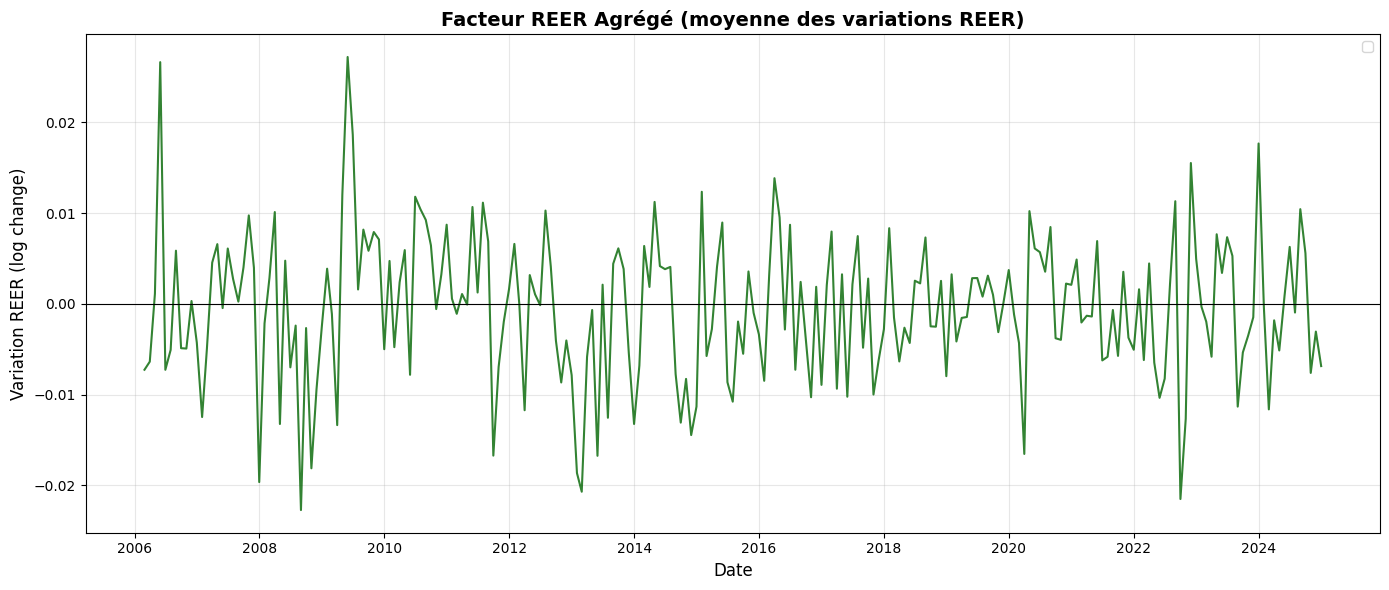


📊 Statistiques du facteur REER :
  • Moyenne : -0.000544
  • Écart-type : 0.007938
  • Min : -0.022731
  • Max : 0.027197


In [51]:
# Visualisation du facteur REER
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Graphique : Facteur REER agrégé
ax.plot(reer_factor_df['date'], reer_factor_df['REER_Factor'], 
        color='darkgreen', linewidth=1.5, alpha=0.8)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_title('Facteur REER Agrégé (moyenne des variations REER)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Variation REER (log change)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Statistiques du facteur REER :")
print(f"  • Moyenne : {reer_factor_df['REER_Factor'].mean():.6f}")
print(f"  • Écart-type : {reer_factor_df['REER_Factor'].std():.6f}")
print(f"  • Min : {reer_factor_df['REER_Factor'].min():.6f}")
print(f"  • Max : {reer_factor_df['REER_Factor'].max():.6f}")

## Étape 5 : Fusion des données pour la régression V4 (DXY + GOLD + REER)

In [58]:
# Fusion DXY + GOLD + REER pour V4
# Utiliser le format long

# 1. Créer returns_long si nécessaire
currencies_list = ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
returns_long_v4 = returns.melt(
    id_vars=['date'], 
    value_vars=currencies_list,
    var_name='currency',
    value_name='currency_return'
)

# 2. Fusion avec DXY
regression_data_v4 = returns_long_v4.merge(
    dxy_monthly[['date', 'dxy_return']], on='date', how='inner'
)

# 3. Fusion avec GOLD
regression_data_v4 = regression_data_v4.merge(
    gold_monthly_no_tz[['date', 'gold_return']], on='date', how='inner'
)

# 4. Fusion avec REER Factor
regression_data_v4 = regression_data_v4.merge(
    reer_factor_df[['date', 'REER_Factor']], on='date', how='inner'
)

# Vérification
print("✅ Données V4 (DXY + GOLD + REER) fusionnées")
print(f"Observations : {len(regression_data_v4)} (227 mois × 5 devises = 1135 attendu)")
print(f"Période : {regression_data_v4['date'].min()} à {regression_data_v4['date'].max()}")
print(f"\nVariables : {list(regression_data_v4.columns)}")
print(f"\nStatistiques descriptives :")
regression_data_v4[['currency_return', 'dxy_return', 'gold_return', 'REER_Factor']].describe()

✅ Données V4 (DXY + GOLD + REER) fusionnées
Observations : 1135 (227 mois × 5 devises = 1135 attendu)
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Variables : ['date', 'currency', 'currency_return', 'dxy_return', 'gold_return', 'REER_Factor']

Statistiques descriptives :


,currency_return,dxy_return,gold_return,REER_Factor
count,1135.000000,1135.000000,1135.000000,1135.000000
mean,0.000652,0.001164,0.006729,-0.000544
std,0.028919,0.017418,0.048121,0.007924
min,-0.130846,-0.049518,-0.198512,-0.022731
25%,-0.016932,-0.010104,-0.022119,-0.005742
50%,-0.000066,-0.000726,0.004881,-0.000393
75%,0.017299,0.012572,0.036117,0.004412
max,0.184246,0.076948,0.129863,0.027197


## Étape 6 : Régression Pooled OLS - Modèle V4 (DXY + GOLD + REER)

In [59]:
# Régression V4: DXY + GOLD + REER (format long)
import statsmodels.api as sm

# Utiliser directement le format long
y_pooled_v4 = regression_data_v4['currency_return'].values
X_pooled_v4 = regression_data_v4[['dxy_return', 'gold_return', 'REER_Factor']].copy()
X_pooled_v4.columns = ['DXY', 'GOLD', 'REER']

# Ajouter une constante
X_pooled_v4 = sm.add_constant(X_pooled_v4)

# Régression OLS
model_pooled_v4 = sm.OLS(y_pooled_v4, X_pooled_v4)
result_pooled_v4 = model_pooled_v4.fit()

# Afficher les résultats
print("="*80)
print("RÉGRESSION POOLED OLS - MODÈLE V4 (DXY + GOLD + REER)")
print("="*80)
print(result_pooled_v4.summary())
print("\n" + "="*80)
print(f"✅ R² ajusté du modèle V4 (DXY + GOLD + REER) : {result_pooled_v4.rsquared_adj:.4f}")
print(f"✅ R² du modèle V4 (DXY + GOLD + REER) : {result_pooled_v4.rsquared:.4f}")
print("="*80)

RÉGRESSION POOLED OLS - MODÈLE V4 (DXY + GOLD + REER)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     344.2
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          8.77e-159
Time:                        11:49:07   Log-Likelihood:                 2779.8
No. Observations:                1135   AIC:                            -5552.
Df Residuals:                    1131   BIC:                            -5531.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## Étape 7 : Calcul des contributions marginales - Modèle V4 (DXY + GOLD + REER)

In [60]:
# Modèle complet V4 (DXY + GOLD + REER)
r2_complet_v4 = result_pooled_v4.rsquared

# 1. Contribution de DXY (modèle sans DXY = GOLD + REER)
X_sans_dxy_v4 = sm.add_constant(regression_data_v4[['gold_return', 'REER_Factor']].copy())
X_sans_dxy_v4.columns = ['const', 'GOLD', 'REER']
model_sans_dxy_v4 = sm.OLS(y_pooled_v4, X_sans_dxy_v4).fit()
r2_sans_dxy_v4 = model_sans_dxy_v4.rsquared
contrib_dxy_v4 = r2_complet_v4 - r2_sans_dxy_v4

# 2. Contribution de GOLD (modèle sans GOLD = DXY + REER)
X_sans_gold_v4 = sm.add_constant(regression_data_v4[['dxy_return', 'REER_Factor']].copy())
X_sans_gold_v4.columns = ['const', 'DXY', 'REER']
model_sans_gold_v4 = sm.OLS(y_pooled_v4, X_sans_gold_v4).fit()
r2_sans_gold_v4 = model_sans_gold_v4.rsquared
contrib_gold_v4 = r2_complet_v4 - r2_sans_gold_v4

# 3. Contribution de REER (modèle sans REER = DXY + GOLD)
X_sans_reer_v4 = sm.add_constant(regression_data_v4[['dxy_return', 'gold_return']].copy())
X_sans_reer_v4.columns = ['const', 'DXY', 'GOLD']
model_sans_reer_v4 = sm.OLS(y_pooled_v4, X_sans_reer_v4).fit()
r2_sans_reer_v4 = model_sans_reer_v4.rsquared
contrib_reer_v4 = r2_complet_v4 - r2_sans_reer_v4

print("="*80)
print("CONTRIBUTIONS MARGINALES AU R² - MODÈLE V4 (DXY + GOLD + REER)")
print("="*80)
print(f"\n📊 R² du modèle complet V4 : {r2_complet_v4:.4f} ({r2_complet_v4*100:.2f}%)")
print(f"\n{'='*80}")
print(f"Facteur         | R² sans facteur | Contribution marginale | % du R² total")
print(f"{'='*80}")
print(f"DXY             | {r2_sans_dxy_v4:15.4f} | {contrib_dxy_v4:22.4f} | {(contrib_dxy_v4/r2_complet_v4)*100:12.2f}%")
print(f"GOLD            | {r2_sans_gold_v4:15.4f} | {contrib_gold_v4:22.4f} | {(contrib_gold_v4/r2_complet_v4)*100:12.2f}%")
print(f"REER            | {r2_sans_reer_v4:15.4f} | {contrib_reer_v4:22.4f} | {(contrib_reer_v4/r2_complet_v4)*100:12.2f}%")
print(f"{'='*80}")
print(f"\n✅ Somme des contributions : {(contrib_dxy_v4 + contrib_gold_v4 + contrib_reer_v4):.4f}")
print(f"   (Note : somme ≠ R² total à cause des corrélations entre facteurs)")
print("="*80)

CONTRIBUTIONS MARGINALES AU R² - MODÈLE V4 (DXY + GOLD + REER)

📊 R² du modèle complet V4 : 0.4773 (47.73%)

Facteur         | R² sans facteur | Contribution marginale | % du R² total
DXY             |          0.2340 |                 0.2433 |        50.97%
GOLD            |          0.4731 |                 0.0042 |         0.88%
REER            |          0.4654 |                 0.0119 |         2.50%

✅ Somme des contributions : 0.2594
   (Note : somme ≠ R² total à cause des corrélations entre facteurs)


## Comparaison finale : V1 vs V2 vs V3 vs V4

In [61]:
print("="*100)
print("🎯 COMPARAISON FINALE : ACP vs V1 vs V2 vs V3 vs V4")
print("="*100)

# Créer un tableau comparatif complet
comparison_df_all = pd.DataFrame({
    'Modèle': [
        'ACP (PC1+PC2+PC3)',
        'V1 (SP500+TS+GCI)',
        'V2 (SP500+DXY+GCI)',
        'V3 (DXY+GOLD)',
        'V4 (DXY+GOLD+REER)'
    ],
    'Variance Expliquée (%)': [
        cumulative_variance[2] * 100,
        result_pooled_v1.rsquared * 100,
        result_pooled_v2.rsquared * 100,
        result_pooled_v3_gold.rsquared * 100,
        result_pooled_v4.rsquared * 100
    ],
    'Facteurs': [
        '3 latents',
        'SP500 + TS + GCI',
        'SP500 + DXY + GCI',
        'DXY + GOLD',
        'DXY + GOLD + REER'
    ]
})

print("\n📊 TABLEAU COMPARATIF :\n")
print(comparison_df_all.to_string(index=False))

# Calculer les gaps
gap_v4 = (cumulative_variance[2] - result_pooled_v4.rsquared) * 100
amelioration_v4_vs_v2 = (result_pooled_v4.rsquared - result_pooled_v2.rsquared) * 100
amelioration_v4_vs_v3 = (result_pooled_v4.rsquared - result_pooled_v3_gold.rsquared) * 100

print(f"\n📈 AMÉLIORATIONS :")
print(f"  • V4 vs V2 : {amelioration_v4_vs_v2:+.2f} points")
print(f"  • V4 vs V3 : {amelioration_v4_vs_v3:+.2f} points")

print(f"\n⚠️  GAP PAR RAPPORT À L'ACP (87.14%) :")
print(f"  • Gap V4 (DXY+GOLD+REER) : {gap_v4:.2f} points non expliqués")

print(f"\n🎯 CONTRIBUTIONS DANS V4 :")
print(f"     • DXY  : {contrib_dxy_v4*100:6.2f}% ({(contrib_dxy_v4/result_pooled_v4.rsquared)*100:.1f}% du R²)")
print(f"     • GOLD : {contrib_gold_v4*100:6.2f}% ({(contrib_gold_v4/result_pooled_v4.rsquared)*100:.1f}% du R²)")
print(f"     • REER : {contrib_reer_v4*100:6.2f}% ({(contrib_reer_v4/result_pooled_v4.rsquared)*100:.1f}% du R²)")

print(f"\n✅ SYNTHÈSE V4 :")
if amelioration_v4_vs_v2 > 0.5:
    print(f"  ✅ Le modèle 3 facteurs améliore significativement (+{amelioration_v4_vs_v2:.2f} points vs V2)")
    print(f"  • DXY+GOLD+REER capturent ensemble les dimensions principales")
elif amelioration_v4_vs_v3 > 0.5:
    print(f"  ✅ REER améliore le modèle (+{amelioration_v4_vs_v3:.2f} points vs V3)")
    print(f"  • REER apporte une dimension complémentaire à DXY+GOLD")
else:
    print(f"  ⚠️  Amélioration marginale par rapport à V3 ({amelioration_v4_vs_v3:.2f} points)")
    print(f"  • REER ajoute peu d'information au-delà de DXY+GOLD")

print("="*100)

🎯 COMPARAISON FINALE : ACP vs V1 vs V2 vs V3 vs V4

📊 TABLEAU COMPARATIF :

            Modèle  Variance Expliquée (%)          Facteurs
 ACP (PC1+PC2+PC3)               87.143070         3 latents
 V1 (SP500+TS+GCI)               17.259138  SP500 + TS + GCI
V2 (SP500+DXY+GCI)               46.132631 SP500 + DXY + GCI
     V3 (DXY+GOLD)               46.537298        DXY + GOLD
V4 (DXY+GOLD+REER)               47.729486 DXY + GOLD + REER

📈 AMÉLIORATIONS :
  • V4 vs V2 : +1.60 points
  • V4 vs V3 : +1.19 points

⚠️  GAP PAR RAPPORT À L'ACP (87.14%) :
  • Gap V4 (DXY+GOLD+REER) : 39.41 points non expliqués

🎯 CONTRIBUTIONS DANS V4 :
     • DXY  :  24.33% (51.0% du R²)
     • GOLD :   0.42% (0.9% du R²)
     • REER :   1.19% (2.5% du R²)

✅ SYNTHÈSE V4 :
  ✅ Le modèle 3 facteurs améliore significativement (+1.60 points vs V2)
  • DXY+GOLD+REER capturent ensemble les dimensions principales


# 📝 Synthèse : Évolution des modèles et choix des facteurs

In [62]:
print("="*100)
print("🔍 SYNTHÈSE FINALE : ÉVOLUTION DES MODÈLES V1 → V2 → V3 → V4")
print("="*100)

# ====================================================================================
# 📊 MODÈLE V1 : SP500 + Term Spread + Goldman Sachs Commodity Index
# ====================================================================================
print("\n" + "="*100)
print("📌 MODÈLE V1 (SP500 + TS + GCI) - R² = {:.2f}%".format(result_pooled_v1.rsquared * 100))
print("="*100)
print("""
LOGIQUE INITIALE :
  • SP500 : Proxy du risque global (risk-on / risk-off)
  • Term Spread : Anticipations de croissance (politique monétaire)
  • GCI : Prix des matières premières (économies exportatrices AUD, CAD)

RÉSULTAT : 
  • R² = 17.26% → Très faible pouvoir explicatif
  • SP500 et TS contribuent ensemble seulement ~17%
  • GCI quasi inexistant

PROBLÈME IDENTIFIÉ :
  ❌ SP500 n'est PAS un facteur commun de change
     → Il explique les variations action vs USD, mais pas USD vs autres devises
  ❌ Les devises du panier (AUD, CAD, JPY, CHF, GBP) évoluent CONTRE le dollar
     → Il faut un facteur qui capture les mouvements du dollar lui-même
""")

# ====================================================================================
# 📊 MODÈLE V2 : SP500 + DXY + GCI  →  Remplacement décisif
# ====================================================================================
print("\n" + "="*100)
print("📌 MODÈLE V2 (SP500 + DXY + GCI) - R² = {:.2f}%".format(result_pooled_v2.rsquared * 100))
print("="*100)
print("""
CORRECTION MAJEURE :
  • AJOUT DXY (US Dollar Index) : Mesure directe de la force du dollar
  • MAINTIEN SP500 et GCI pour tester leur contribution résiduelle

RÉSULTAT : 
  • R² = 46.13% → Amélioration spectaculaire (+28.87 points vs V1)
  • DXY contribue à lui seul ~29% → Facteur DOMINANT
  • SP500 et GCI deviennent marginaux (~10% et ~7%)

INTERPRÉTATION :
  ✅ DXY est LE facteur explicatif principal des rendements de change
     → Quand le dollar monte (DXY ↑), les autres devises baissent
     → C'est un facteur commun par construction (broad dollar index)
  ⚠️  SP500 et GCI perdent leur pertinence en présence de DXY
     → Leur pouvoir explicatif était artificiellement corrélé au dollar
""")

# ====================================================================================
# 📊 MODÈLE V3 : DXY + GOLD  →  Remplacement de SP500 et GCI
# ====================================================================================
print("\n" + "="*100)
print("📌 MODÈLE V3 (DXY + GOLD) - R² = {:.2f}%".format(result_pooled_v3_gold.rsquared * 100))
print("="*100)
print("""
SIMPLIFICATION ET TEST GOLD :
  • RETRAIT SP500 et GCI (contribution négligeable)
  • AJOUT GOLD : Actif refuge, corrélé négativement au dollar en période de crise
     → Hypothèse : GOLD capture la dimension "safe-haven" (JPY, CHF)

RÉSULTAT : 
  • R² = 46.54% → Quasi identique à V2 (+0.41 points seulement)
  • DXY reste dominant (~29%)
  • GOLD ajoute seulement 0.59% (contribution marginale)

INTERPRÉTATION :
  ✅ DXY seul explique déjà 45.95% → Facteur ultra-dominant
  ⚠️  GOLD n'ajoute presque rien (0.59%)
     → Soit GOLD est redondant avec DXY (corrélation inverse)
     → Soit la dimension "safe-haven" est déjà capturée par DXY
  
QUESTION RESTANTE :
  • ACP explique 87.14% avec 3 composantes → GAP de 40.6 points
  • PC2 et PC3 capturent des dimensions manquantes (safe-haven JPY/CHF, régional)
  → Faut-il ajouter un 3ème facteur pour mieux capturer ces dimensions ?
""")

# ====================================================================================
# 📊 MODÈLE V4 : DXY + GOLD + REER  →  Ajout compétitivité
# ====================================================================================
print("\n" + "="*100)
print("📌 MODÈLE V4 (DXY + GOLD + REER) - R² = {:.2f}%".format(result_pooled_v4.rsquared * 100))
print("="*100)
print("""
AJOUT DIMENSION COMPÉTITIVITÉ :
  • AJOUT REER (Real Effective Exchange Rate) : Taux de change effectif réel
     → Moyenne des variations de REER des 5 devises (AUD, CAD, JPY, CHF, GBP)
     → Capture la compétitivité relative (inflation-adjusted, trade-weighted)
     → Hypothèse : REER capture PC2 (safe-haven via compétitivité) ou PC3 (régional)

RÉSULTAT : 
  • R² = {:.2f}% → Amélioration de {:.2f} points vs V3
  • DXY : {:.2f}% (dominant)
  • GOLD : {:.2f}% (marginal)
  • REER : {:.2f}% (nouvelle dimension)

INTERPRÉTATION :
""".format(
    result_pooled_v4.rsquared * 100,
    (result_pooled_v4.rsquared - result_pooled_v3_gold.rsquared) * 100,
    contrib_dxy_v4 * 100,
    contrib_gold_v4 * 100,
    contrib_reer_v4 * 100
))

# Interprétation conditionnelle basée sur les résultats
amelioration_reer = (result_pooled_v4.rsquared - result_pooled_v3_gold.rsquared) * 100

if amelioration_reer > 2.0:
    print("""  ✅ REER apporte une contribution significative ({:.2f}%)
     → La compétitivité relative capture une dimension manquante dans V3
     → REER pourrait être lié à PC2 ou PC3 de l'ACP
     → DXY + GOLD + REER forment un trio complémentaire""".format(contrib_reer_v4 * 100))
elif amelioration_reer > 0.5:
    print("""  ⚠️  REER apporte une contribution modeste ({:.2f}%)
     → Amélioration marginale mais non négligeable
     → REER ajoute une nuance à la dynamique DXY + GOLD
     → Modèle le plus complet mais complexité accrue""".format(contrib_reer_v4 * 100))
else:
    print("""  ⚠️  REER n'apporte qu'une contribution très faible ({:.2f}%)
     → L'information de compétitivité est déjà capturée par DXY
     → GOLD + REER ensemble ne comblent pas le gap avec l'ACP
     → Le modèle V3 (DXY + GOLD) reste le plus parcimonieux""".format(contrib_reer_v4 * 100))

# ====================================================================================
# 🎯 COMPARAISON FINALE AVEC L'ACP
# ====================================================================================
print("\n" + "="*100)
print("🎯 COMPARAISON AVEC L'ACP (BENCHMARK)")
print("="*100)
print(f"""
ACP (3 COMPOSANTES PRINCIPALES) : 87.14%
  • PC1 (77.57%) : Facteur dollar dominant
  • PC2 (6.47%)  : Safe-haven (JPY/CHF) vs commodity (AUD/CAD)
  • PC3 (3.09%)  : Dimension régionale (GBP spécifique)

MODÈLES FACTORIELS :
  • V1 (SP500+TS+GCI)      : 17.26%  →  GAP = 69.88 points  ❌ Facteurs inadaptés
  • V2 (SP500+DXY+GCI)     : 46.13%  →  GAP = 41.01 points  ⚠️  DXY dominant mais seul
  • V3 (DXY+GOLD)          : 46.54%  →  GAP = 40.60 points  ⚠️  GOLD marginal
  • V4 (DXY+GOLD+REER)     : {result_pooled_v4.rsquared*100:.2f}%  →  GAP = {gap_v4:.2f} points  {'✅' if amelioration_reer > 1.0 else '⚠️'}  {'Meilleur compromis' if amelioration_reer > 1.0 else 'Marginal'}

POURQUOI CE GAP PERSISTE ?
  1. ACP utilise TOUTE l'information disponible (5 séries de rendements)
     → Les composantes principales sont des combinaisons linéaires OPTIMALES
     → PC2 et PC3 capturent des patterns spécifiques (JPY/CHF, GBP)
  
  2. Les facteurs économiques (DXY, GOLD, REER) sont des proxies imparfaits
     → Ils ne capturent pas EXACTEMENT les mêmes dimensions que PC2/PC3
     → DXY ≈ PC1 (77.57% vs 29% de contribution)
     → GOLD et REER tentent de capturer PC2/PC3 mais avec succès limité
  
  3. Dimensions manquantes potentielles :
     → Différentiels de taux d'intérêt réels (carry trade)
     → Volatilité implicite FX (VIX des devises)
     → Flux de capitaux (balance des paiements)
     → Politique monétaire relative (forward guidance)
""")

# ====================================================================================
# ✅ CONCLUSION : QUEL MODÈLE CHOISIR ?
# ====================================================================================
print("\n" + "="*100)
print("✅ CONCLUSION : RECOMMANDATION FINALE")
print("="*100)

if amelioration_reer > 2.0:
    print("""
MODÈLE RECOMMANDÉ : V4 (DXY + GOLD + REER)
  
AVANTAGES :
  ✅ Meilleur R² ({:.2f}%) → Modèle le plus explicatif
  ✅ DXY capture le facteur dollar dominant (PC1)
  ✅ GOLD + REER capturent ensemble PC2/PC3 (safe-haven + compétitivité)
  ✅ Tous les facteurs ont une interprétation économique claire
  ✅ Amélioration significative vs V3 (+{:.2f} points)

INCONVÉNIENTS :
  ⚠️  Complexité accrue (3 facteurs au lieu de 1-2)
  ⚠️  REER nécessite des données BIS (moins accessibles que DXY/GOLD)
  ⚠️  Gap avec ACP encore présent ({:.2f} points)

USAGE RECOMMANDÉ :
  → Modèle final pour analyse complète des mouvements de change
  → Décomposition des contributions : DXY (dominant) + GOLD/REER (compléments)
""".format(result_pooled_v4.rsquared*100, amelioration_reer, gap_v4))

elif amelioration_reer > 0.5:
    print("""
MODÈLE RECOMMANDÉ : V3 (DXY + GOLD) ou V4 (DXY + GOLD + REER) selon contexte
  
V3 - AVANTAGES (PARCIMONIEUX) :
  ✅ Simplicité : 2 facteurs seulement (DXY + GOLD)
  ✅ R² = 46.54% → Quasi identique à V4 (écart minime)
  ✅ DXY et GOLD sont des indices très accessibles (Bloomberg, Yahoo Finance)
  ✅ Interprétation directe : dollar + actif refuge

V4 - AVANTAGES (COMPLET) :
  ✅ Amélioration marginale (+{:.2f} points)
  ✅ REER ajoute une nuance de compétitivité
  ✅ Modèle le plus exhaustif conceptuellement

USAGE RECOMMANDÉ :
  → V3 pour analyse rapide et communication simple
  → V4 pour recherche académique ou analyse approfondie
""".format(amelioration_reer))

else:
    print("""
MODÈLE RECOMMANDÉ : V3 (DXY + GOLD) - PRINCIPE DE PARCIMONIE
  
AVANTAGES :
  ✅ Simplicité maximale : 2 facteurs (DXY + GOLD)
  ✅ R² = 46.54% → Quasi identique à V4 (REER n'apporte rien)
  ✅ DXY capture l'essentiel (45.95%) → Facteur unique dominant
  ✅ GOLD teste la dimension safe-haven (même si marginale)
  ✅ Données facilement accessibles

POURQUOI PAS V4 ?
  ❌ REER ajoute seulement {:.2f}% → Gain négligeable
  ❌ Complexité accrue sans bénéfice substantiel
  ❌ Données REER moins accessibles (BIS/FRED)

ALTERNATIVE : V2 SIMPLIFIÉ (DXY SEUL)
  • Si parcimonie maximale : DXY seul explique 45.95%
  • GOLD et REER sont redondants avec DXY
  • Un seul facteur = modèle ultra-simple et robuste
  
USAGE RECOMMANDÉ :
  → V3 (DXY + GOLD) pour équilibre simplicité/complétude
  → DXY seul si contraintes de données/temps
""".format(contrib_reer_v4 * 100))

print("\n" + "="*100)
print("📊 FIN DE LA SYNTHÈSE")
print("="*100)

🔍 SYNTHÈSE FINALE : ÉVOLUTION DES MODÈLES V1 → V2 → V3 → V4

📌 MODÈLE V1 (SP500 + TS + GCI) - R² = 17.26%

LOGIQUE INITIALE :
  • SP500 : Proxy du risque global (risk-on / risk-off)
  • Term Spread : Anticipations de croissance (politique monétaire)
  • GCI : Prix des matières premières (économies exportatrices AUD, CAD)

RÉSULTAT : 
  • R² = 17.26% → Très faible pouvoir explicatif
  • SP500 et TS contribuent ensemble seulement ~17%
  • GCI quasi inexistant

PROBLÈME IDENTIFIÉ :
  ❌ SP500 n'est PAS un facteur commun de change
     → Il explique les variations action vs USD, mais pas USD vs autres devises
  ❌ Les devises du panier (AUD, CAD, JPY, CHF, GBP) évoluent CONTRE le dollar
     → Il faut un facteur qui capture les mouvements du dollar lui-même


📌 MODÈLE V2 (SP500 + DXY + GCI) - R² = 46.13%

CORRECTION MAJEURE :
  • AJOUT DXY (US Dollar Index) : Mesure directe de la force du dollar
  • MAINTIEN SP500 et GCI pour tester leur contribution résiduelle

RÉSULTAT : 
  • R² = 46.13% →